# **Informe – Proyecto Final Bioinformática**

*Clasificación Taxonómica a Partir de Sesgos en el Uso de Codones*

Universidad del Norte Santo Tomas de Aquino

Bravo Lopez Joaquin

**Introducción**

El código genético es universal, pero los organismos no emplean todos los codones con la misma frecuencia para codificar aminoácidos. Este fenómeno, conocido como sesgo en el uso de codones (codon usage bias), refleja procesos de adaptación evolutiva, eficiencia en la traducción y presiones selectivas propias de cada grupo taxonómico.

El análisis de estos patrones permite distinguir entre dominios y linajes (como bacterias, arqueas, virus, eucariotas) e incluso entre elementos móviles como plásmidos o fagos. Estas diferencias hacen del sesgo en el uso de codones una herramienta bioinformática valiosa para estudios de filogenia, evolución molecular y clasificación taxonómica.

En este proyecto se aplican diversos algoritmos de machine learning con el objetivo de construir modelos predictivos capaces de clasificar organismos según su perfil de uso de codones, explorando su potencial como descriptor evolutivo y taxonómico.

**Dataset**

Fuente: UCI Machine Learning Repository – Codon Usage Dataset. Link: https://archive.ics.uci.edu/dataset/577/codon+usage

* Instancias: 13.028.

* Atributos: 69 (frecuencias de uso de codones).

* Clases (salida esperada):

  1. bct → bacterias (eubacterias)

  2. arc → arqueas

  3. vrl → virus

  4. phg → fagos (bacteriófagos)

  5. plm → plásmidos bacterianos

  6. pln → plantas

  7. vrt → vertebrados

  8. mam → mamíferos

  9. pri → primates

  10. rod → roedores

  11. inv → invertebrados

Cada fila corresponde al perfil de uso de codones de un organismo o secuencia, y la tarea de clasificación consiste en predecir el grupo taxonómico al que pertenece. Los valores en las columnas de los codones representan las proporciones/frecuencias de uso de cada codón en las secuencias codificantes del organismo.

**Objetivos**

General: Evaluar la capacidad de algoritmos de machine learning para clasificar organismos en distintos grupos taxonómicos a partir de su sesgo en el uso de codones.

Específicos:

* Realizar un análisis exploratorio del dataset para identificar patrones de codon usage.

* Implementar modelos de Árbol de Decisión, Random Forest, SVM y Deep Learning.

* Validar y comparar el rendimiento de los modelos utilizando métricas de clasificación.

* Determinar qué codones tienen mayor relevancia para la clasificación

**1. Importacion y Primera Vista del Dataset**

In [ ]:
# LIBRERÍAS PRINCIPALES
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import math

# MACHINE LEARNING (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Modelos supervisados
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Métricas y evaluación
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix,
    adjusted_rand_score, normalized_mutual_info_score
)

# DEEP LEARNING (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import layers, models

# CLUSTERING Y REDUCCIÓN DE DIMENSIONALIDAD
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import linear_sum_assignment

In [ ]:
# Para montar el drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Para cargar el CSV desde drive
ruta_csv = "/content/drive/MyDrive/CARRERA 4TO AÑO/BIOINFORMATICA/codon_usage.csv"
df = pd.read_csv(ruta_csv)
df

/tmp/ipython-input-1055080220.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_csv)


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Aca podemos ver que el dataset reúne información sobre la frecuencia relativa de uso de cada uno de los 64 codones en distintos organismos y elementos genéticos. Cada fila del dataset representa el perfil de uso de codones de una especie, virus o elemento genético (por ejemplo, un plásmido o mitocondria).

Las primeras columnas contienen metadatos asociados a cada entrada:

* Kingdom: grupo taxonómico al que pertenece la secuencia (por ejemplo: vrl para virus, pri para primates, bct para bacterias, etc.).

* DNAtype: tipo de material genético (0 = ADN, 1 = ARN).

* SpeciesID: identificador numérico de la especie en la base de datos.

* Ncodons: número total de codones considerados en el cálculo de las frecuencias.

* SpeciesName: nombre de la especie o del elemento genético.

A continuación, se incluyen 64 columnas (de UUU a UGA) que representan las frecuencias relativas de cada codón dentro del genoma o conjunto de genes analizados. Los valores están normalizados entre 0 y 1, de modo que expresan proporciones respecto al total de codones empleados.



In [ ]:
# Inspección rápida
print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist()[:10], " ...")
print("\nPrimeras filas:\n")
display(df.head(3))

Shape: (13028, 69)

Columnas: ['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU', 'UUC', 'UUA', 'UUG', 'CUU']  ...

Primeras filas:



,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144


In [ ]:
# Defino X (features) e y (clase)
# La clase será la columna Kingdom
y = df["Kingdom"]

# Los Features serian todos los codones
# (excluyo columnas no informativas como SpeciesID, SpeciesName, DNAtype, Ncodons)
X = df.drop(columns=["Kingdom", "DNAtype", "SpeciesID", "Ncodons", "SpeciesName"])

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (13028, 64)
Shape de y: (13028,)


Kingdom
bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: count, dtype: int64
Total 13028


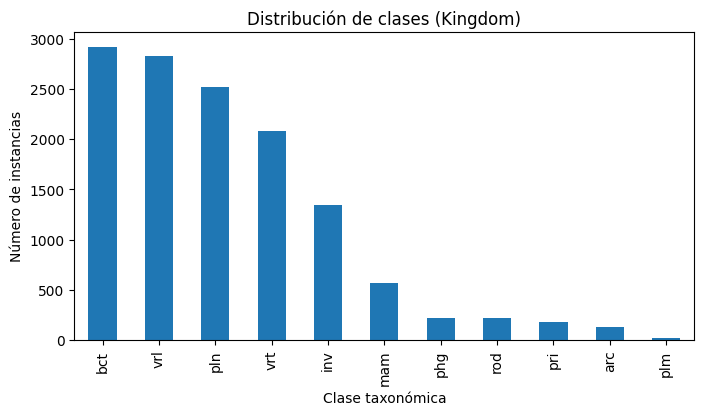

In [ ]:
# Distribución de clases
clases_total = y.value_counts()
print(clases_total)
total_frecuencias = clases_total.sum()
print(f"Total {total_frecuencias}")

plt.figure(figsize=(8,4))
clases_total.plot(kind="bar")
plt.title("Distribución de clases (Kingdom)")
plt.xlabel("Clase taxonómica")
plt.ylabel("Número de instancias")
plt.show()

Con esto obtengo lo siguiente:

* X = frecuencias de 64 codones.

* y = grupo taxonómico (Kingdom).

Puedo ver cuántas instancias hay de cada clase (para ver si hay desbalance).

En la figura se observa un desequilibrio considerable entre los grupos: las categorías bct (bacterias), vrl (virus), pln (plantas) y vrt (vertebrados) concentran la mayor cantidad de instancias, superando ampliamente las 2000 muestras cada una.

En contraste, clases como arc (arqueas), pri (primates), rod (roedores) y phg (fagos) están representadas por un número mucho menor de ejemplos, mientras que plm (plásmidos bacterianos) es la clase más escasa.

Este desbalance de clases implica que los modelos podrían tender a favorecer las categorías mayoritarias, reduciendo la sensibilidad hacia las minoritarias. Por ello, en las etapas posteriores se consideró el uso de estrategias como pesos de clase balanceados (class_weight='balanced') para compensar este efecto en los algoritmos empleados.

El análisis confirma que el dataset, aunque suficientemente grande (más de 13 mil instancias), no está uniformemente distribuido entre las categorías taxonómicas, lo que convierte este problema en un caso típico de clasificación multiclase desbalanceada.

**2. Preparación**

In [ ]:
# Para convertir cualquier valor de celda a float
# asegurando que los valores no numéricos o mal
# formateados se transformen en NaN
def to_float(cell):
    s = str(cell).strip().replace(",", ".")  # por si hay comas decimales, las reemplaza por puntos
    # solo acepto si es un número válido (float o notación científica)
    pattern = r"^[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?$"

    if re.fullmatch(pattern, s):
        return float(s)
    else:
        return np.nan

In [ ]:
# Test de prueba
test_de_prueba = ["0,34", "12;I", "non-B", "1.23e-4", "12;34", "0.89%", " 0.5 "]
for t in test_de_prueba:
    print(t, "->", to_float(t))

0,34 -> 0.34
12;I -> nan
non-B -> nan
1.23e-4 -> 0.000123
12;34 -> nan
0.89% -> nan
 0.5  -> 0.5


In [ ]:
# Aplico la funcion to_float() a cada celda de las 64 columnas de codones
X_num = X.applymap(to_float) # Cada celda de X se convierte en número flotante (float) si es válida, y en NaN si contiene texto u otro valor inválido.

# Para invalidar valores fuera de rango [0,1] (las frecuencias deben ser proporciones)
rango_01 = (X_num >= 0) & (X_num <= 1)
X_num = X_num.where(rango_01, np.nan) # Los valores fuera del rango se reemplazan por NaN

/tmp/ipython-input-1050963525.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_num = X.applymap(to_float) # Cada celda de X se convierte en número flotante (float) si es válida, y en NaN si contiene texto u otro valor inválido.


In [ ]:
# Revisa cada fila del DataFrame X_num (ya limpio de la etapa anterior) y detecta
# si tiene algún valor NaN (es decir, una celda vacía, no numérica o fuera de rango).
filas_erroneas = X_num.isna().any(axis=1)
print("Filas descartadas por datos inválidos:", int(filas_erroneas.sum()))

# Para quedarme con datos limpios y alinear y
X_clean = X_num.loc[~filas_erroneas].copy()
y_clean = y.loc[X_clean.index].copy()

print("Shape limpio:", X_clean.shape)
print("Clases después de limpiar:")
print(y_clean.value_counts())

Filas descartadas por datos inválidos: 2
Shape limpio: (13026, 64)
Clases después de limpiar:
Kingdom
bct    2919
vrl    2831
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: count, dtype: int64


Durante la limpieza del dataset, desarolle una función de conversión (to_float) para garantizar que los valores de las 64 variables de frecuencia de codones fueran interpretados correctamente como números decimales.

Se aceptaron únicamente valores que corresponden a un número decimal válido (con punto o coma como separador decimal, opcionalmente en notación científica, y con espacios tolerados).

Cualquier celda que contuviera caracteres adicionales (símbolos, letras, separadores irregulares, porcentajes, etc.) fue considerada inválida y reemplazada por un valor faltante (NaN).

Este criterio evita interpretar de forma errónea valores contaminados y asegura que las frecuencias utilizadas en los modelos correspondan a datos confiables dentro del rango esperado.

In [ ]:
# Train/Test (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_clean, y_clean, test_size=0.20, stratify=y_clean, random_state=42
)

# De ese 80% de train, saco 20% para valid (queda 64/16/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42
)

print("Tamaños de los conjuntos para Arbol de Decision y Random Forest:")
print("\nTamaño del conjunto de entrenamiento:", len(X_train_full))
print("Tamaño del conjunto de prueba:", len(X_test))

print("\nTamaños de los conjuntos para MLP y SVM:")
print("\nTamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaños de los conjuntos para Arbol de Decision y Random Forest:

Tamaño del conjunto de entrenamiento: 10420
Tamaño del conjunto de prueba: 2606

Tamaños de los conjuntos para MLP y SVM:

Tamaño del conjunto de entrenamiento: 8336
Tamaño del conjunto de validación: 2084
Tamaño del conjunto de prueba: 2606


En el proyecto trabajé con dos esquemas de partición de datos:

* Conjunto completo (full) → utilizado para Árbol de Decisión y Random Forest.

Estos algoritmos basados en árboles no son sensibles a la escala de las variables, ya que dividen los datos según umbrales absolutos. Por eso se usó una división simple en entrenamiento y prueba (train_full/test).

* Conjunto escalado y con validación (sin full) → utilizado para SVM y MLP. En cambio, estos modelos sí son sensibles a la magnitud de las variables:

En SVM, las distancias y márgenes de separación dependen directamente de la escala de los datos.

En MLP, las activaciones y gradientes también pueden verse afectadas si las variables tienen rangos distintos.

Por eso hice uso de un escalado Min–Max (normalizando cada variable entre 0 y 1) y se usó una división en tres subconjuntos:

* Entrenamiento (64%): para ajustar los pesos del modelo.

* Validación (16%): para ajustar hiperparámetros y evitar sobreajuste.

* Prueba (20%): para evaluar el desempeño final en datos no vistos.

In [ ]:
# Para verificar las proporciones para Arbol de Decision y Random Forest
def resumen(y, nombre):
    vc = y.value_counts(normalize=True).sort_index()
    print(f"{nombre}  (n={len(y)})")
    print((vc*100).round(2))

resumen(y_train_full, "Train")
resumen(y_test,  "Test")

Train  (n=10420)
Kingdom
arc     0.97
bct    22.41
inv    10.33
mam     4.40
phg     1.69
plm     0.13
pln    19.37
pri     1.38
rod     1.65
vrl    21.74
vrt    15.94
Name: proportion, dtype: float64
Test  (n=2606)
Kingdom
arc     0.96
bct    22.41
inv    10.32
mam     4.37
phg     1.69
plm     0.15
pln    19.38
pri     1.38
rod     1.65
vrl    21.72
vrt    15.96
Name: proportion, dtype: float64


In [ ]:
# Para verificar las proporciones para MLP y SVM
resumen(y_train, "Train")
resumen(y_val,   "Valid")
resumen(y_test,  "Test")

Train  (n=8336)
Kingdom
arc     0.97
bct    22.41
inv    10.33
mam     4.39
phg     1.69
plm     0.13
pln    19.36
pri     1.38
rod     1.66
vrl    21.74
vrt    15.94
Name: proportion, dtype: float64
Valid  (n=2084)
Kingdom
arc     0.96
bct    22.41
inv    10.32
mam     4.41
phg     1.68
plm     0.14
pln    19.39
pri     1.39
rod     1.63
vrl    21.74
vrt    15.93
Name: proportion, dtype: float64
Test  (n=2606)
Kingdom
arc     0.96
bct    22.41
inv    10.32
mam     4.37
phg     1.69
plm     0.15
pln    19.38
pri     1.38
rod     1.65
vrl    21.72
vrt    15.96
Name: proportion, dtype: float64


In [ ]:
# Escalado para MLP y SVM
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

**3. Modelos Utilizados**

En esta parte del código creé dos estructuras vacías que sirven como “cajas” donde se van a ir guardando todos los resultados de los modelos a medida que se entrenen.

* resultados_df

Es un DataFrame de pandas con columnas predefinidas (model, split, accuracy, balanced_acc, f1_macro, etc).

Funciona como una tabla resumen que acumula la información de cada modelo que se pruebe.

Así, al final puedo comparar en un solo lugar todas las métricas clave.

* reports

Es un diccionario de Python.

Guarda los classification reports completos (precision, recall, F1 por clase) de cada modelo y cada split (por ejemplo: Árbol en test, SVM en validación).

In [ ]:
reports = {}

In [ ]:
try:
    resultados_df
except NameError:
    resultados_df = pd.DataFrame(columns=[
        "model","split","accuracy","balanced_acc","f1_macro","depth","n_leaves"
    ])

try:
    reports
except NameError:
    reports = {}

En la celda de abajo defini una función auxiliar que permite estandarizar el proceso de entrenamiento y evaluación de cada modelo. Esta función recibe como entrada un clasificador, su nombre, los datos de entrenamiento y de evaluación, y devuelve tanto las predicciones como un registro con las métricas principales.

De esta forma, evaluacion_y_almacenamiento centraliza el flujo de evaluación, garantiza que todos los modelos se documenten de manera uniforme y facilita la comparación de resultados en tablas y reportes individuales.

In [ ]:
def evaluacion_y_almacenamiento(model, model_name, X_tr, y_tr, X_te, y_te,
                       split_name="test", extra_info=None, dedup=True):
    """Entrena, evalúa y guarda métricas + classification_report en resultados_df / reports."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc     = accuracy_score(y_te, y_pred)
    bal_acc = balanced_accuracy_score(y_te, y_pred)
    f1m     = f1_score(y_te, y_pred, average="macro")
    crep    = classification_report(y_te, y_pred)

    row = {"model": model_name, "split": split_name,
           "accuracy": acc, "balanced_acc": bal_acc, "f1_macro": f1m}
    if extra_info:
        row.update(extra_info)

    # Para agregar/sobrescribir la fila en resultados_df
    global resultados_df
    new_row = pd.DataFrame([row])
    if dedup and not resultados_df.empty:
        resultados_df = pd.concat([resultados_df, new_row], ignore_index=True)
        resultados_df = resultados_df.drop_duplicates(subset=["model","split"], keep="last")
    else:
        resultados_df = pd.concat([resultados_df, new_row], ignore_index=True)

    # Para guardar el classification_report de forma accesible
    global reports
    reports[(model_name, split_name)] = crep

    return y_pred, row

Cuando se entrena un modelo de clasificación (como Árbol de Decisión, Random Forest, SVM o MLP), no basta con mirar una sola métrica. Por eso, eligi fijarme en el Accuracy, Balanced Accuracy y F1-score (macro), que aportan una visión distinta y complementaria del rendimiento del modelo.

1. Accuracy (Precisión global)

Que mide el porcentaje total de aciertos (predicciones correctas) sobre todas las muestras. Sin embargo, en datasets desbalanceados (como es el caso), donde algunas clases tienen muchas más muestras que otras, la accuracy puede ser engañosa, porque el modelo puede predecir bien solo las clases mayoritarias y aun así parecer “preciso”.

2. Balanced Accuracy

Mide el promedio de la recall (sensibilidad) obtenida en cada clase. En este caso cada clase aporta el mismo peso, sin importar cuántas muestras tenga. Compensa los efectos del desbalance de clases, dándole la misma importancia a cada una. Si una clase “rara” (como arc) se predice mal pero el resto se predice bien, la accuracy apenas se altera, pero la balanced accuracy baja significativamente, mostrando el problema.

3. F1-score (macro)

Mide el promedio del F1-score calculado por clase. El F1 combina precisión (evita falsos positivos) y recall (evita falsos negativos). La versión macro trata todas las clases por igual, sin ponderar por tamaño. Es una métrica más exigente, que penaliza los errores en clases minoritarias. Si el modelo se equivoca mucho en una clase pequeña, el F1-macro lo refleja fuertemente, incluso si la accuracy general sigue siendo alta.

# **Visualizacion y Exploracion de los Datos**

# *PCA*

El Principal Component Analysis (PCA) es una técnica de reducción de dimensionalidad que transforma un conjunto de variables correlacionadas (en este caso, las frecuencias de los 64 codones) en un nuevo conjunto de variables llamadas componentes principales (PCs).
Cada componente principal es una combinación lineal de los codones originales y representa una dirección en el espacio de los datos que maximiza la varianza, es decir, la cantidad de información o dispersión explicada.

El objetivo del PCA no es clasificar, sino identificar patrones o relaciones subyacentes entre los organismos y ver si los grupos taxonómicos se separan naturalmente según su uso de codones.

In [ ]:
# Normalización para PCA
scaler_pca = MinMaxScaler()
X_norm_pca = scaler_pca.fit_transform(X_clean)
feature_names = X_clean.columns.to_list()

In [ ]:
# PCA sobre TODO el dataset
pca = PCA(n_components=None)   # aprende todas las PCs para ver varianza total
X_pca = pca.fit_transform(X_norm_pca)

# DataFrame con los resultados del PCA
pca_df = pd.DataFrame({
    'standard_deviation': np.sqrt(pca.explained_variance_),
    'proportion_of_variance': pca.explained_variance_ratio_,
    'cumulative_proportion': np.cumsum(pca.explained_variance_ratio_)
}, index=[f'PC{i}' for i in range(1, X_pca.shape[1]+1)])
pca_df.index.name = 'component'

print("Resumen de PCA (todas las PCs):")
display(pca_df)

Resumen de PCA (todas las PCs):


,standard_deviation,proportion_of_variance,cumulative_proportion
component,,,
PC1,0.491589,3.514538e-01,0.351454
PC2,0.375326,2.048719e-01,0.556326
PC3,0.198539,5.732689e-02,0.613653
PC4,0.160863,3.763350e-02,0.651286
PC5,0.151849,3.353438e-02,0.684820
...,...,...,...
PC60,0.028196,1.156208e-03,0.997771
PC61,0.027145,1.071644e-03,0.998843
PC62,0.023702,8.169900e-04,0.999660


La tabla resume la varianza capturada por cada componente:

* PC1 explica el 35% de la varianza total.

* PC2 agrega otro 20%, alcanzando un 56% acumulado.

* Hasta PC5, se conserva cerca del 68% de la información original.

Esto significa que con solo unas pocas componentes (de las 64 originales) ya se conserva la mayor parte de la estructura del dataset, es decir, que la información biológicamente relevante puede representarse en pocas PCs.

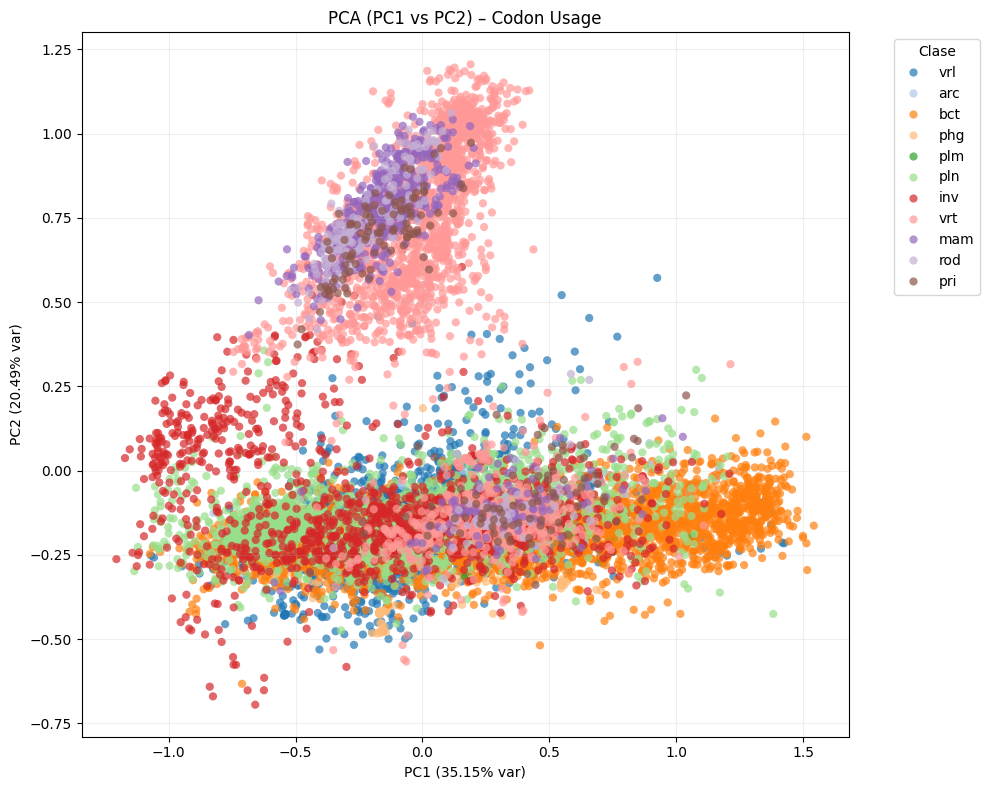

In [ ]:
# Scatter PC1 vs PC2 coloreado por clase
pca_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Kingdom': y_clean.values
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Kingdom', palette='tab20', s=35, alpha=0.7, edgecolor='none')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)')
plt.title('PCA (PC1 vs PC2) – Codon Usage')
plt.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


En el gráfico de dispersión se muestra la distribución de los organismos proyectados sobre los dos primeros componentes (PC1 y PC2). Se observan ciertas agrupaciones:
* Mamíferos, primates y roedores quedan en la parte superior, bastante separados.
* Bacterias, virus, plantas tienden a solaparse más en la parte inferior/central.

Entonces puedo decir que el uso de codones sí refleja diferencias taxonómicas, aunque algunas clases tienen más solapamiento que otras.

In [ ]:
# Loadings (vectores de carga)
# Transpongo para tener (n_features, n_components)
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=feature_names, columns=[f'PC{i}' for i in range(1, X_pca.shape[1]+1)])
print("Loadings (contribución de cada codón a cada PC):")
display(loadings_df.iloc[:, :6])  # mostrar para PC1..PC6

Loadings (contribución de cada codón a cada PC):


,PC1,PC2,PC3,PC4,PC5,PC6
UUU,-0.119100,-0.014794,0.143384,0.083016,0.092346,-0.104241
UUC,0.099992,0.208790,-0.098595,0.188309,-0.034320,0.274954
UUA,-0.208237,0.046054,0.312885,-0.080997,0.050188,-0.152190
UUG,-0.052231,-0.136427,-0.038828,0.144403,0.077919,0.033681
CUU,-0.095006,0.121138,-0.048083,0.083080,0.425103,-0.080363
...,...,...,...,...,...,...
GAA,-0.091553,-0.114676,-0.002595,-0.162144,-0.149194,0.204859
GAG,0.117278,-0.137218,-0.108006,0.048007,-0.049138,-0.079821
UAA,-0.018926,0.021952,-0.000780,-0.049313,0.012120,-0.005378
UAG,-0.001399,-0.002559,-0.012614,0.003062,0.005431,-0.022880


Los loadings indican cuánto aporta cada codón a la construcción de cada componente principal.
Son los “pesos” que determinan qué variables (codones) influyen más en cada eje del PCA.

Por ejemplo, en la tabla se observa que:

* El codón UUA tiene un peso alto y negativo en PC1, lo que significa que los organismos con alta frecuencia relativa de UUA se ubican hacia los valores bajos del eje PC1.

* En cambio, codones como UUC o GAG tienen pesos positivos, desplazando a las especies hacia valores altos.

Estos valores permiten identificar qué codones son más determinantes en las diferencias entre grupos taxonómicos.

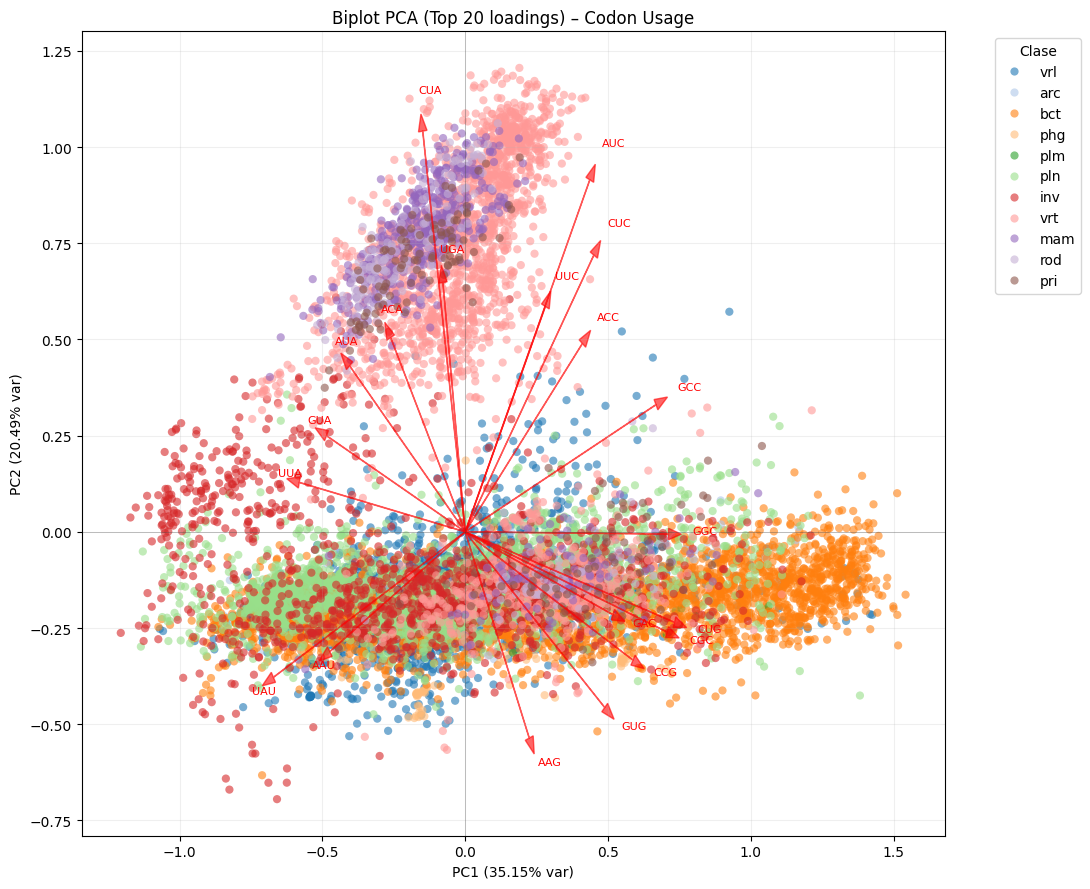

In [ ]:
# Biplot (PC1–PC2 + flechas de loadings)
# Para que el gráfico no sea ilegible, muestro las top-20 variables por contribución en PC1–PC2
# Mido contribución por norma del vector en las dos primeras PCs
contrib = np.linalg.norm(loadings[:, :2], axis=1)
top_k = 20
top_idx = np.argsort(contrib)[-top_k:]

# Escala de flechas: ajusto para que entren en el gráfico
escala = 3.0

plt.figure(figsize=(11, 9))
sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Kingdom', palette='tab20', s=35, alpha=0.6, edgecolor='none')

for i in top_idx:
    x_vec = loadings[i, 0] * escala
    y_vec = loadings[i, 1] * escala
    plt.arrow(0, 0, x_vec, y_vec, color='red', alpha=0.6, head_width=0.03, length_includes_head=True)
    plt.text(x_vec*1.05, y_vec*1.05, feature_names[i], color='red', fontsize=8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)')
plt.title(f'Biplot PCA (Top {top_k} loadings) – Codon Usage')
plt.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.axhline(0, color='k', lw=0.5, alpha=0.3)
plt.axvline(0, color='k', lw=0.5, alpha=0.3)
plt.tight_layout()
plt.show()

El biplot superpone la proyección de los organismos con las flechas (loadings) de los codones más influyentes en las primeras dos componentes.

Las flechas más largas (por ejemplo, CUA, AUC) representan codones con mayor peso en la separación entre grupos.
La dirección de cada flecha indica hacia qué región del gráfico aumenta la frecuencia relativa de ese codón.

Esto permite establecer un vínculo biológico: por ejemplo, si los mamíferos se agrupan hacia la zona superior del gráfico, los codones con flechas que apuntan en esa dirección son más comunes en ellos, mientras que otros codones caracterizan a bacterias o virus.

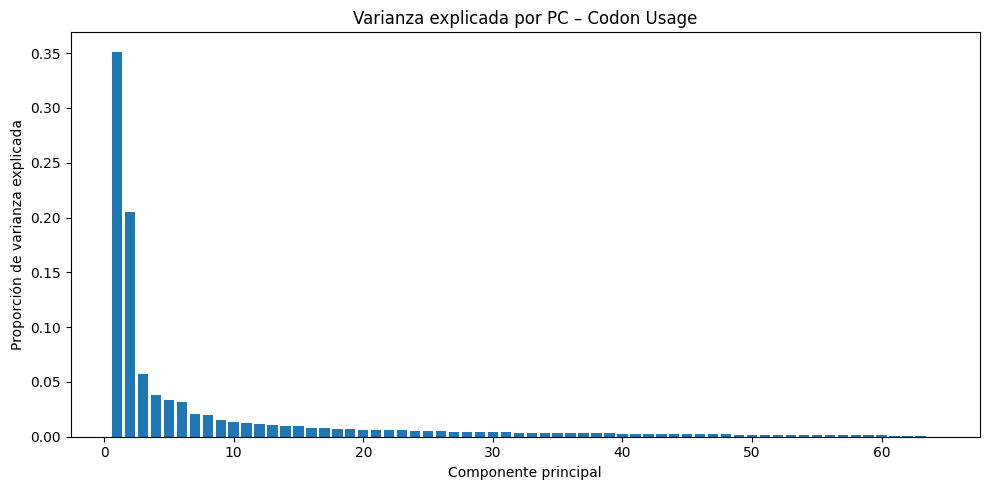

In [ ]:
# Varianza explicada por componente (barras)
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, X_pca.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.title('Varianza explicada por PC – Codon Usage')
plt.tight_layout()
plt.show()

La primera barra (PC1) explica ~35%.

La segunda (PC2) explica ~20%.

Después las barras bajan muy rápido, en PC2–PC3.

Esto significa que gran parte de la información ya se concentra en las primeras 2–3 PCs, lo que justifica que el scatter PC1–PC2 sea representativo.

**Conclusion**

El PCA confirma que existen patrones estructurados y biológicamente coherentes en el uso de codones entre diferentes grupos taxonómicos. Los organismos no se distribuyen aleatoriamente: grupos como mamíferos, primates y roedores presentan perfiles más definidos, mientras que virus y bacterias tienden a solaparse parcialmente, lo que concuerda con su diversidad y variabilidad genética.

Las dos primeras componentes (PC1 y PC2) capturan más de la mitad de la información total, lo que las hace útiles para visualización y análisis exploratorio.
Además, los loadings permiten identificar qué codones son los que más contribuyen a las diferencias entre clases.

**Aclaracion**

K-Means es un algoritmo no supervisado (clustering), que no usa etiquetas. Su rendimiento depende de la separación geométrica de los datos en el espacio, buscando minimizar la distancia media entre los puntos y su centroide. En datasets con muchas variables correlacionadas (como los codones), los clusters pueden estar “aplastados” o redundantes, por lo que se vuelve difícil de separar en 64 dimensiones. Por eso es muy común aplicar PCA antes de K-Means para reducir la dimensionalidad a 2–10 PCs, para poder:

* Eliminar ruido/redundancia.

* Aumentar la separabilidad entre grupos.

PCA en los metodos que usare mas adelante, en los modelos de clasificacion supervisada (Árbol, RF, SVM, MLP), no lo considero necesario aplicarlo porque esos métodos ya manejan bien alta dimensionalidad:

* Árboles/Random Forest: seleccionan automáticamente variables relevantes.

* SVM: funciona bien con escalado y puede usar kernels que separan en espacios de mayor dimensión.

* MLP: puede aprender representaciones internas (es como su propio PCA “no lineal”).

# *K-means*

In [ ]:
# Preparación para clustering
# Escalado
scaler_km = MinMaxScaler()
X_norm_km = scaler_km.fit_transform(X_clean)

**CON PCA**

In [ ]:
# PCA para clustering
# n_components=0.90 para ~90% var y mejor calidad de clusters
pca_km = PCA(n_components=0.90, svd_solver='full')
X_pca_km = pca_km.fit_transform(X_norm_km)

In [ ]:
# Para graficar en 2D:
# n_components=2 para graficar
pca_plot = PCA(n_components=2)
X_pca2 = pca_plot.fit_transform(X_norm_km)

print(f"Dimensión PCA para clustering: {X_pca_km.shape[1]} PCs (≈{pca_km.explained_variance_ratio_.sum()*100:.1f}% var)")

Dimensión PCA para clustering: 25 PCs (≈90.4% var)


En este caso considere conservar las componentes necesarias para explicar el 90% de la varianza, lo que redujo la dimensionalidad de 64 a 25 PCs, manteniendo prácticamente toda la información relevante.

Además, utilice una versión de 2 componentes (PC1–PC2) solo para visualización.

In [ ]:
# K-Means
n_clusters = y_clean.nunique()           # 11 clases
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca_km)

In [ ]:
# Mapeo cluster
# Asegúrate de que y_clean esté alineado con X_pca2/kmeans_labels
cont = pd.crosstab(kmeans_labels, y_clean)
dom_class = cont.idxmax(axis=1)

# Paleta fija por cluster
colors = sns.color_palette("tab20", n_colors=n_clusters)
palette = {c: colors[c] for c in range(n_clusters)}

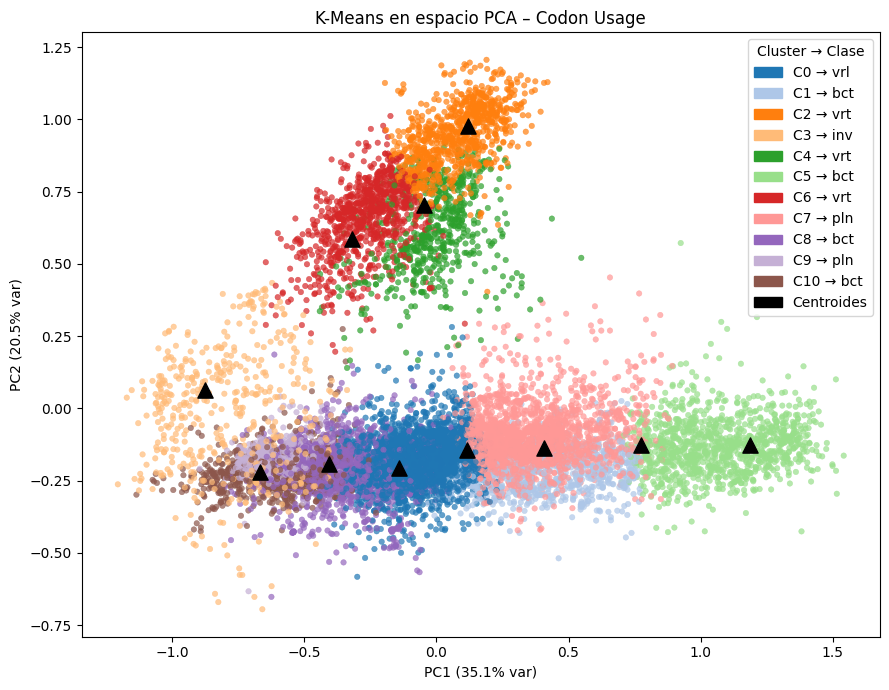

In [ ]:
# Visualización en PC1–PC2
# Proyecto los CENTROIDES aprendidos en el espacio de 2 PCs para plot
kmeans_2d = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
labels_2d = kmeans_2d.fit_predict(X_pca2)
centroids_2d = kmeans_2d.cluster_centers_ # Centroides

plt.figure(figsize=(9,7))
sns.scatterplot(
    x=X_pca2[:,0], y=X_pca2[:,1],
    hue=kmeans_labels, palette=palette,
    s=16, alpha=0.7, edgecolor=None, legend=False
)
plt.scatter(
    centroids_2d[:,0], centroids_2d[:,1],
    marker='^', s=120, c='black', label='Centroides'
)

plt.xlabel(f"PC1 ({pca_plot.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_plot.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("K-Means en espacio PCA – Codon Usage")

# Leyenda: Cluster → Clase dominante (color = cluster)
legend_patches = [Patch(color=palette[c], label=f"C{c} → {dom_class[c]}") for c in range(n_clusters)]
plt.legend(handles=legend_patches + [Patch(facecolor='black', edgecolor='black', label='Centroides')],
           title="Cluster → Clase", loc='best')
plt.tight_layout()
plt.show()

El gráfico muestra la distribución de los organismos en el plano PCA junto con los centroides (triángulos negros) correspondientes a cada uno de los 11 clusters generados.

Se observa que:

* Algunos clusters se alinean con grupos taxonómicos concretos, especialmente bacterias (bct) y vertebrados (vrt), que forman zonas densas y compactas.

* Otros grupos, como virus (vrl) o plásmidos (plm), aparecen más dispersos o mezclados con clases cercanas, lo que indica una superposición significativa entre perfiles de codon usage.

Direct agreement (Hungarian): 35.97%


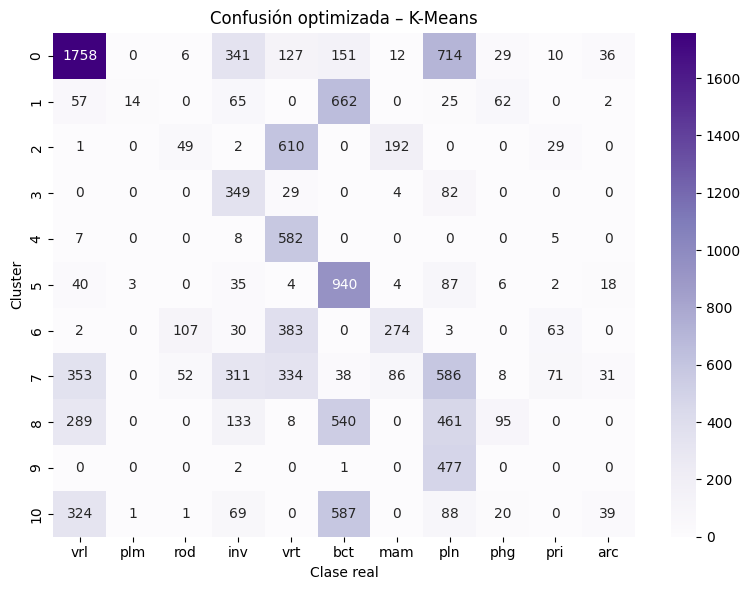

In [ ]:
# Tabla de confusión optimizada (Hungarian)
y_true = y_clean.values
y_pred = kmeans_labels

# Tabla de confusión inicial
cont_table = pd.crosstab(y_pred, y_true, rownames=['Cluster'], colnames=['Clase real'])

# Hungarian para reordenar columnas (max coincidencia)
_, class_match_idx = linear_sum_assignment(-cont_table.values)
cols_reordenadas_1 = cont_table.columns[class_match_idx]
optimized_cont_table = cont_table[cols_reordenadas_1].copy()

# Mapeo de cada cluster
mapped = np.empty_like(y_pred, dtype=object)
for ci, col in enumerate(cols_reordenadas_1):
    mapped[y_pred == ci] = col

# Exactitud tras el mapeo
direct_agreement = accuracy_score(y_true, mapped) * 100
print(f"Direct agreement (Hungarian): {direct_agreement:.2f}%")

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(optimized_cont_table, annot=True, fmt="d", cmap="Purples")
plt.title("Confusión optimizada – K-Means")
plt.tight_layout(); plt.show()

Para evaluar cuantitativamente la correspondencia entre los clusters y las clases reales, hice uso del algoritmo de asignación de Hungarian, que empareja cada cluster con la clase más probable, maximizando el acuerdo global. El Direct Agreement obtenido fue de 35.97%, lo que significa que aproximadamente un tercio de las muestras fueron correctamente asignadas tras el mejor emparejamiento posible.

Este valor no es bajo considerando que:

* K-Means no utiliza etiquetas durante el entrenamiento.

* Las clases reales no son perfectamente separables ni esféricas.

* Existe desbalance de clases, lo que hace que clusters grandes “absorban” organismos similares de clases pequeñas.

La matriz de confusión optimizada muestra que los clusters agrupan correctamente ciertas clases grandes (por ejemplo, bacterias o vertebrados), mientras que otras quedan mezcladas.

---

Para separar taxones de forma supervisada, los demas modelos modelos (SVM/MLP) son mucho más eficaces; K-Means sirve aquí como análisis exploratorio.

In [ ]:
# Para guardar resultado de K-Means (con Hungarian matching) en resultados_df
row_kmeans = {
    "model": "K-Means (Hungarian, PCA+MinMax)",
    "split": "test",
    "accuracy": direct_agreement/100,   # accuracy expresado como proporción
    "balanced_acc": np.nan,             # no aplica directamente en clustering
    "f1_macro": np.nan,                 # no aplica directamente
    "depth": np.nan,
    "n_leaves": np.nan,
    "oob_score": np.nan,
    "n_trees": np.nan,
    "C": np.nan,
}

resultados_df = pd.concat([resultados_df, pd.DataFrame([row_kmeans])], ignore_index=True)
resultados_df = resultados_df.drop_duplicates(subset=["model","split"], keep="last")
resultados_df = resultados_df.drop(columns=['kernel1'], errors='ignore')
# Mostrar tabla actualizada
print("\n")
display(resultados_df.sort_values(["split","accuracy"], ascending=[True, False]))

/tmp/ipython-input-2387234811.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_df = pd.concat([resultados_df, pd.DataFrame([row_kmeans])], ignore_index=True)


,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión del análisis con K-Means**

El uso combinado de PCA y K-Means me permitió explorar la estructura global del dataset.
Los resultados muestran que existen tendencias naturales de agrupamiento en el uso de codones, pero la taxonomía biológica no puede recuperarse completamente mediante métodos puramente no supervisados.

El 35.97% de coincidencia directa confirma que, aunque los patrones existen, se requiere supervisión para lograr una clasificación precisa.

**Clustering jerárquico**

El clustering jerárquico es otro método no supervisado que, a diferencia de K-Means, no requiere especificar el número de clusters a priori.
En lugar de particionar directamente el espacio, construye una jerarquía de agrupamientos: cada muestra comienza como un cluster individual, y en cada paso se van fusionando los más similares hasta formar una estructura en forma de árbol (dendrograma).

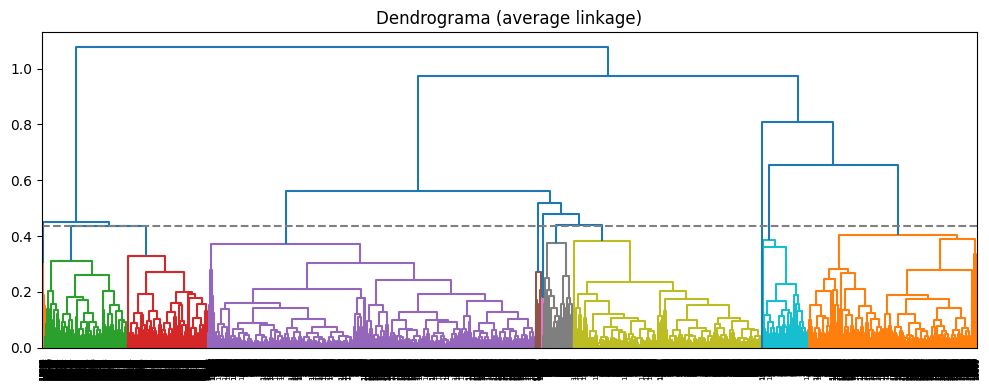

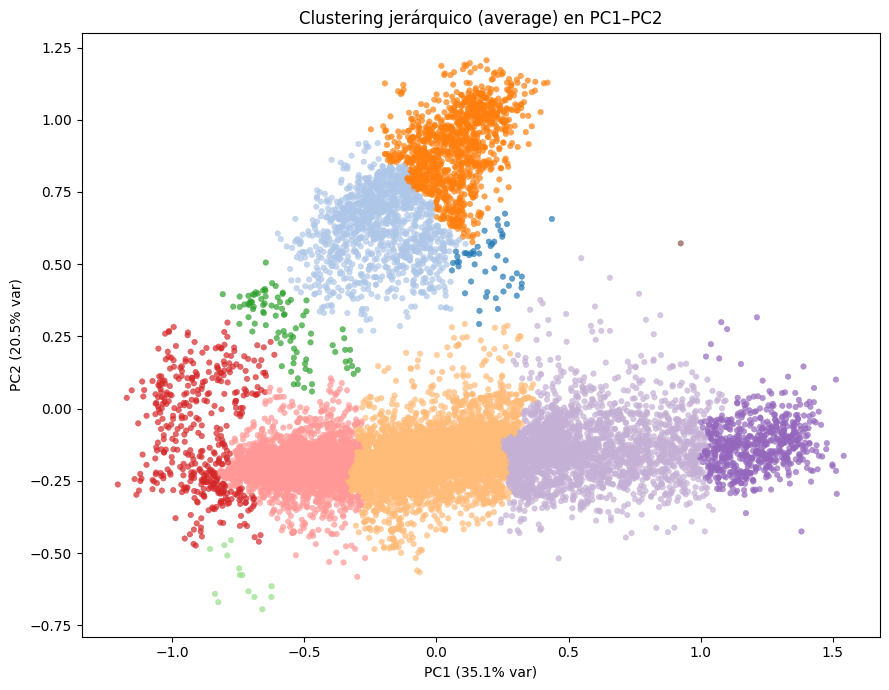

In [ ]:
# Uso las mismas X_norm_km y X_pca2 (2 PCs para graficar)
Z = linkage(X_pca2, method='average')
y_pred_h = fcluster(Z, t=n_clusters, criterion='maxclust')

# Dendrograma con línea de corte a k clusters
plt.figure(figsize=(10,4))
dendrogram(Z, color_threshold=Z[-n_clusters+1,2])
plt.axhline(y=Z[-n_clusters+1,2], color='gray', ls='--')
plt.title("Dendrograma (average linkage)")
plt.tight_layout(); plt.show()

# Scatter por cluster jerárquico
plt.figure(figsize=(9,7))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y_pred_h, palette='tab20', s=16, alpha=0.7, edgecolor=None, legend=False)
plt.xlabel(f"PC1 ({pca_plot.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_plot.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Clustering jerárquico (average) en PC1–PC2")
plt.tight_layout(); plt.show()

1) Dendrograma (average linkage)

Cada hoja del dendrograma representa una muestra, y las ramas indican las uniones sucesivas entre grupos de muestras.
El eje Y muestra la distancia promedio entre clusters (average linkage) en el momento de cada fusión.

La línea horizontal punteada marca el umbral de corte: al trazarla, el árbol se “corta” en ese nivel y se obtienen los k clusters resultantes (en este caso, 11 para compararlos con las clases reales del dataset).

Si las uniones grandes ocurren a alturas elevadas, significa que los clusters son compactos internamente y están bien separados entre sí, lo que se traduce en agrupamientos más definidos.

En este caso se observa estructura jerárquica coherente, con varios grupos bien definidos (ramas altas y separadas), lo que indica que existen patrones de similitud marcados en los perfiles de uso de codones. Los clusters grandes en la base del dendrograma corresponden a grupos taxonómicos amplios y con alto número de instancias, como bacterias o virus.

2) Scatter en PC1–PC2 coloreado por cluster

En el segundo gráfico se representan las mismas muestras proyectadas sobre las dos primeras componentes principales (PC1 y PC2), coloreadas según el cluster jerárquico al que pertenecen.

Se observan zonas densas de diferente color, lo que indica que el modelo jerárquico logró dividir el espacio PCA en regiones coherentes.
Si bien algunos grupos se solapan (especialmente en la zona central donde coinciden bacterias, virus y plantas), el patrón general es biológicamente plausible, con varios grupos bien definidos.

Este gráfico permite validar visualmente la consistencia geométrica de los clusters detectados en el dendrograma.

Direct agreement (Jerárquico-average): 38.85%


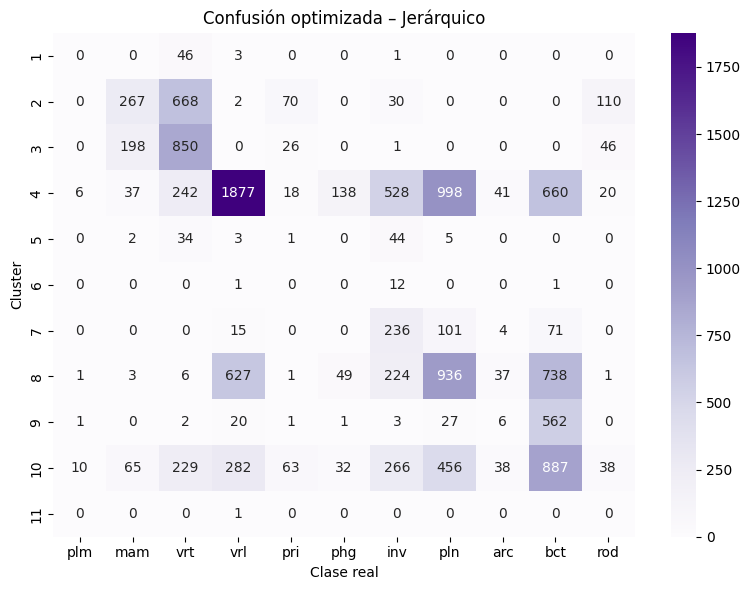

In [ ]:
# Métrica con Hungarian (igual que en K-Means)
cont_h = pd.crosstab(y_pred_h, y_true, rownames=['Cluster'], colnames=['Clase real'])
_, class_match_idx_h = linear_sum_assignment(-cont_h.values)     # maximizamos coincidencias
cols_reordenadas_h = cont_h.columns[class_match_idx_h]
opt_h = cont_h[cols_reordenadas_h].copy()

mapped_h = np.empty_like(y_pred_h, dtype=object)
for ci, col in enumerate(cols_reordenadas_h):
    mapped_h[y_pred_h == (ci+1)] = col   # fcluster da 1..k

acc_h = accuracy_score(y_true, mapped_h) * 100
print(f"Direct agreement (Jerárquico-average): {acc_h:.2f}%")

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(opt_h, annot=True, fmt="d", cmap="Purples")
plt.title("Confusión optimizada – Jerárquico")
plt.tight_layout(); plt.show()

Para cuantificar la relación entre los clusters jerárquicos y las clases taxonómicas reales, use nuevamente el emparejamiento Hungarian, que asocia cada cluster con la clase más probable.
El resultado se muestra en la tabla de confusión optimizada.

El Direct Agreement (38.85%) indica que, tras la mejor asignación posible entre clusters y clases, casi cuatro de cada diez organismos fueron agrupados correctamente según su categoría taxonómica.

Este rendimiento supera levemente al obtenido con K-Means (35.97%), lo que sugiere que el método jerárquico se adapta un poco mejor a la estructura real del espacio de codones.

Aun así, persisten solapamientos notables, ya que el clustering sigue siendo puramente geométrico y no supervisado.

**K-means sin PCA**

Como análisis complementario, aplique K-Means directamente sobre las 64 variables originales de codon usage, sin realizar reducción de dimensionalidad previa.
El escalado MinMax (rango [0,1]) garantizó que todos los codones tuvieran igual peso en la métrica de distancia usada por el algoritmo.

In [ ]:
# Escalado a [0,1] y datos/labels
X_all = X_clean.values            # 64 codones (limpios)
y_true = y_clean.values           # etiquetas reales (strings)
k = y_clean.nunique()             # nº de clases -> nº de clusters

scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X_all)

#  K-Means en el espacio original (sin PCA)
kmeans_raw = KMeans(
    n_clusters=k, init="k-means++", n_init=20, random_state=42
)
kmeans_labels_raw = kmeans_raw.fit_predict(X_mm)

In [ ]:
# Hungarian para alinear clusters y clases
cont_tabla_raw = pd.crosstab(kmeans_labels_raw, y_true,
                             rownames=['Cluster'], colnames=['Clase real'])

_, class_match_idx_raw = linear_sum_assignment(-cont_tabla_raw.values)
cols_reordenadas_raw = cont_tabla_raw.columns[class_match_idx_raw]
optimizada_cont_tabla_raw = cont_tabla_raw[cols_reordenadas_raw].copy()

print("Tabla de confusión optimizada (K-Means SIN PCA vs clases reales):")
display(optimizada_cont_tabla_raw)

Tabla de confusión optimizada (K-Means SIN PCA vs clases reales):


Clase real,plm,pri,rod,phg,mam,inv,bct,pln,vrl,vrt,arc
Cluster,,,,,,,,,,,
0,14,0,0,63,0,67,667,24,65,1,2
1,0,0,0,0,0,2,0,471,0,0,0
2,0,29,49,0,187,2,0,0,1,608,0
3,0,0,0,98,0,137,569,471,319,8,0
4,0,63,106,0,279,26,0,3,2,355,0
5,0,0,0,0,4,352,0,82,0,30,0
6,3,2,0,6,4,34,945,81,39,4,18
7,0,70,51,8,85,304,32,587,332,328,30
8,0,11,7,27,13,343,133,721,1754,130,37


In [ ]:
# Mapeo de cada cluster
mapped_raw = np.empty_like(kmeans_labels_raw, dtype=object)
for ci, col in enumerate(cols_reordenadas_raw):
    mapped_raw[kmeans_labels_raw == ci] = col

# Métrica de alineamiento
direct_agreement_raw = accuracy_score(y_true, mapped_raw) * 100

print(f"Direct agreement (Hungarian) SIN PCA: {direct_agreement_raw:.2f}%")

Direct agreement (Hungarian) SIN PCA: 36.31%


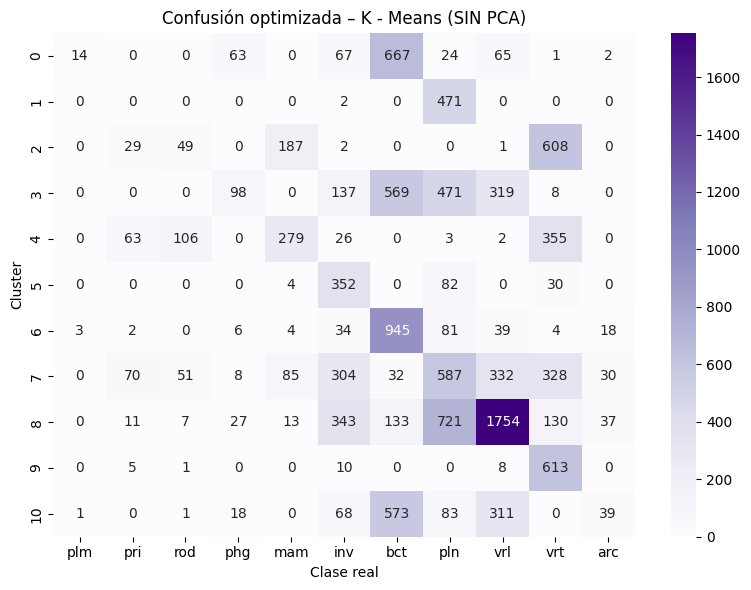

In [ ]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(optimizada_cont_tabla_raw, annot=True, fmt="d", cmap="Purples")
plt.title("Confusión optimizada – K - Means (SIN PCA)")
plt.tight_layout(); plt.show()

Al evaluar los resultados con la asignación Hungarian, se obtuvo un Direct Agreement de 36.31%, muy cercano al 35.97% observado con PCA.
Esto confirma que el PCA no mejora sustancialmente la capacidad de K-Means para reproducir las clases reales.

La matriz de confusión muestra un patrón similar al obtenido con PCA:

* Algunos clusters agrupan correctamente grandes grupos como bacterias (bct) o vertebrados (vrt).

* Sin embargo, otras clases pequeñas o cercanas evolutivamente (por ejemplo, plásmidos o arqueas) quedan mezcladas o absorbidas por clusters mayores.

En conjunto, los resultados confirman que la estructura general del dataset es consistente, pero que K-Means no logra separar las clases con precisión suficiente al basarse solo en distancia geométrica.

In [ ]:
# Para agregar a resultados_df
row_kmeans_raw = {
    "model": "K-Means (sin PCA, MinMax)",
    "split": "test",
    "accuracy": direct_agreement_raw/100,  # en proporción
    "balanced_acc": np.nan,
    "f1_macro": np.nan,
    "depth": np.nan, "n_leaves": np.nan,
    "oob_score": np.nan, "n_trees": np.nan,
    "C": np.nan, "kernel1": np.nan
}
resultados_df = pd.concat([resultados_df, pd.DataFrame([row_kmeans_raw])], ignore_index=True)
resultados_df = resultados_df.drop_duplicates(subset=["model","split"], keep="last")
resultados_df = resultados_df.drop(columns=['kernel1'], errors='ignore')
# Mostrar tabla actualizada
display(resultados_df.sort_values(["split","accuracy"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión comparativa: K-Means con y sin PCA**

El desempeño de K-Means con y sin PCA fue muy similar (≈36% de coincidencia), lo que indica que la reducción de dimensionalidad no altera la estructura global de los datos.

Por tanto:

* PCA + K-Means es más útil para análisis exploratorio e interpretación.

* K-Means sin PCA conserva ligeramente más detalle, pero sigue limitado por la alta correlación entre variables y la naturaleza no esférica de las clases taxonómicas.

Ambos enfoques refuerzan la conclusión de que el sesgo en el uso de codones refleja una organización biológica real, aunque la clasificación precisa requiere modelos supervisados capaces de aprender fronteras más complejas.

# **Metodos Supervisados Empleados para la Clasificacion de los Codones**

# *Arbol de Decision*

El árbol de decisión es un modelo supervisado que clasifica las muestras dividiendo recursivamente el espacio de datos según condiciones sobre las variables más informativas.
Cada nodo representa una pregunta del tipo “¿el valor del codón X es mayor que Y?”, y las ramas llevan a subgrupos cada vez más homogéneos en cuanto a la clase.

El proceso continúa hasta que no se obtiene ganancia de información significativa o se alcanza una profundidad máxima.

In [ ]:
dtc = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    class_weight="balanced",
)
dtc.fit(X_train_full, y_train_full)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=5,
                       random_state=42)

* max_depth=None: no se fija una profundidad máxima, el árbol crece hasta que los nodos sean puros o el criterio deje de mejorar.

* min_samples_leaf=5: cada hoja debe contener al menos 5 muestras; esto evita sobreajuste.

* random_state=42: garantiza reproducibilidad.

* class_weight="balanced": ajusta el peso de cada clase en función de su frecuencia, de modo que las clases minoritarias tengan mayor influencia en la construcción del árbol.

Este enfoque es especialmente útil en datasets desbalanceados, como es el caso, donde bacterias y virus tienen muchas más instancias que arqueas o plásmidos.

In [ ]:
# Entrena + evalúa + guarda (el helper ya hace fit/predict y guarda métricas/report)
y_pred_dt, row_dt = evaluacion_y_almacenamiento(
    dtc, "DecisionTree (entropy, mid=0.03, msl=5)",
    X_train_full, y_train_full,
    X_test, y_test,
    split_name="test",
    extra_info={"depth": None, "n_leaves": None}
)

In [ ]:
# Para completar info estructural del árbol
# Añade a la tabla general dos atributos estructurales del árbol para que queden documentados
row_dt["depth"]    = dtc.get_depth()
row_dt["n_leaves"] = dtc.get_n_leaves()
resultados_df.loc[(resultados_df["model"]==row_dt["model"]) & (resultados_df["split"]=="test"),
               ["depth","n_leaves"]] = [row_dt["depth"], row_dt["n_leaves"]]

In [ ]:
# Predicción y métricas en TEST
print(f"Accuracy (TEST): {row_dt['accuracy']:.3f}")
print(f"Balanced Acc: {row_dt['balanced_acc']:.3f}")
print(f"F1-macro: {row_dt['f1_macro']:.3f}")

Accuracy (TEST): 0.734
Balanced Acc: 0.627
F1-macro: 0.570


In [ ]:
# Información del árbol
print(f"Profundidad del árbol: {dtc.get_depth()}")
print(f"Número de hojas: {dtc.get_n_leaves()}")

Profundidad del árbol: 24
Número de hojas: 717


*Resultados del modelo*

* Accuracy (TEST): 0.734

* Balanced Accuracy: 0.627

* F1-macro: 0.570

* Profundidad del árbol: 24

* Número de hojas: 717

El modelo logra una exactitud global del 73%, lo cual es razonable considerando la complejidad del problema multiclase (11 grupos taxonómicos).
Sin embargo, el Balanced Accuracy (0.63) y el F1-macro (0.57) muestran que la clasificación no es uniforme: las clases minoritarias son más difíciles de reconocer. Esto es coherente con el desbalance del dataset, que el parámetro class_weight="balanced" ayuda parcialmente a mitigar.

In [ ]:
# Ver classification report guardado en TEST
print("Classification report (TEST):\n")
print(reports[("DecisionTree (entropy, mid=0.03, msl=5)", "test")])

Classification report (TEST):

              precision    recall  f1-score   support

         arc       0.34      0.52      0.41        25
         bct       0.87      0.80      0.83       584
         inv       0.55      0.57      0.56       269
         mam       0.58      0.61      0.60       114
         phg       0.37      0.57      0.45        44
         plm       0.17      0.25      0.20         4
         pln       0.77      0.78      0.78       505
         pri       0.27      0.67      0.38        36
         rod       0.39      0.63      0.48        43
         vrl       0.81      0.74      0.77       566
         vrt       0.87      0.76      0.81       416

    accuracy                           0.73      2606
   macro avg       0.54      0.63      0.57      2606
weighted avg       0.76      0.73      0.74      2606



In [ ]:
# Importancias de características (ordenadas)
importancias = dtc.feature_importances_
orden_indices = np.argsort(importancias)[::-1]
print("Variables más importantes (top 20):")
feature_names = X_train_full.columns  # columnas de codones
for idx in orden_indices[:20]:
    print(f"{feature_names[idx]}: {importancias[idx]:.4f}")

Variables más importantes (top 20):
CUA: 0.1206
AGG: 0.0730
CUG: 0.0517
UGA: 0.0423
AUA: 0.0402
CGA: 0.0366
GGA: 0.0355
CGU: 0.0316
UGU: 0.0290
CGC: 0.0250
CGG: 0.0241
GUC: 0.0228
CUU: 0.0219
UUC: 0.0199
UGC: 0.0198
GGU: 0.0173
ACA: 0.0171
AGA: 0.0167
UUG: 0.0161
GAA: 0.0161


Los 20 codones más relevantes para la clasificación incluyen principalmente codones raros o de uso diferencial entre dominios, como CUA, AGG, CUG, UGA, AUA o CGA.
Estos codones suelen variar marcadamente entre organismos procariotas y eucariotas, lo que sugiere que el modelo efectivamente está aprendiendo patrones biológicos reales.

Error de Clase (TEST) por clase:
Clase arc: 0.4800
Clase bct: 0.1952
Clase inv: 0.4349
Clase mam: 0.3860
Clase phg: 0.4318
Clase plm: 0.7500
Clase pln: 0.2178
Clase pri: 0.3333
Clase rod: 0.3721
Clase vrl: 0.2562
Clase vrt: 0.2404


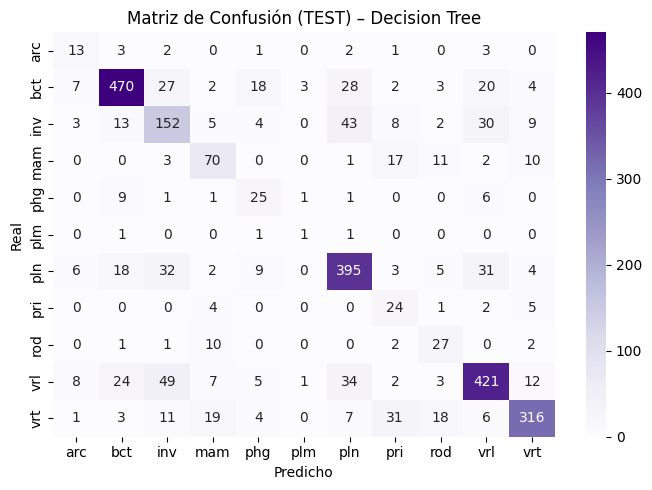

In [ ]:
# Matriz de confusión para el Árbol de Decisión (TEST)
# Uso las clases en el mismo orden que en el entrenamiento
labels = dtc.classes_

# Matriz de confusión
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)
cm_dt_df = pd.DataFrame(cm_dt, index=labels, columns=labels)

# Error de clase (TEST)
clase_error_dt = 1 - np.diag(cm_dt) / np.sum(cm_dt, axis=1)
print("Error de Clase (TEST) por clase:")
for cls, err in zip(labels, clase_error_dt):
    print(f"Clase {cls}: {err:.4f}")

# Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(cm_dt_df, annot=True, cmap="Purples", fmt="d")
plt.title("Matriz de Confusión (TEST) – Decision Tree")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

Con la matriz de confusión podemos observar cómo el modelo clasificó cada clase en el conjunto de prueba.
En ella se destacan varios aspectos importantes:

* Las clases bct (bacterias), vrt (vertebrados), vrl (virus) y pln (plantas) presentan las diagonales más intensas, lo que indica una buena tasa de aciertos.

* Las clases con pocas muestras, como arc (arqueas), plm (plásmidos) y pri (primates), muestran una dispersión más alta, reflejando errores frecuentes de confusión con clases cercanas evolutivamente.

* Se nota cierto solapamiento entre mamíferos, vertebrados y roedores, lo cual es esperable dada su cercanía filogenética y similitud en los patrones de uso de codones.

En conjunto, la matriz confirma una tendencia general correcta, pero con errores concentrados en las clases minoritarias o biológicamente próximas.

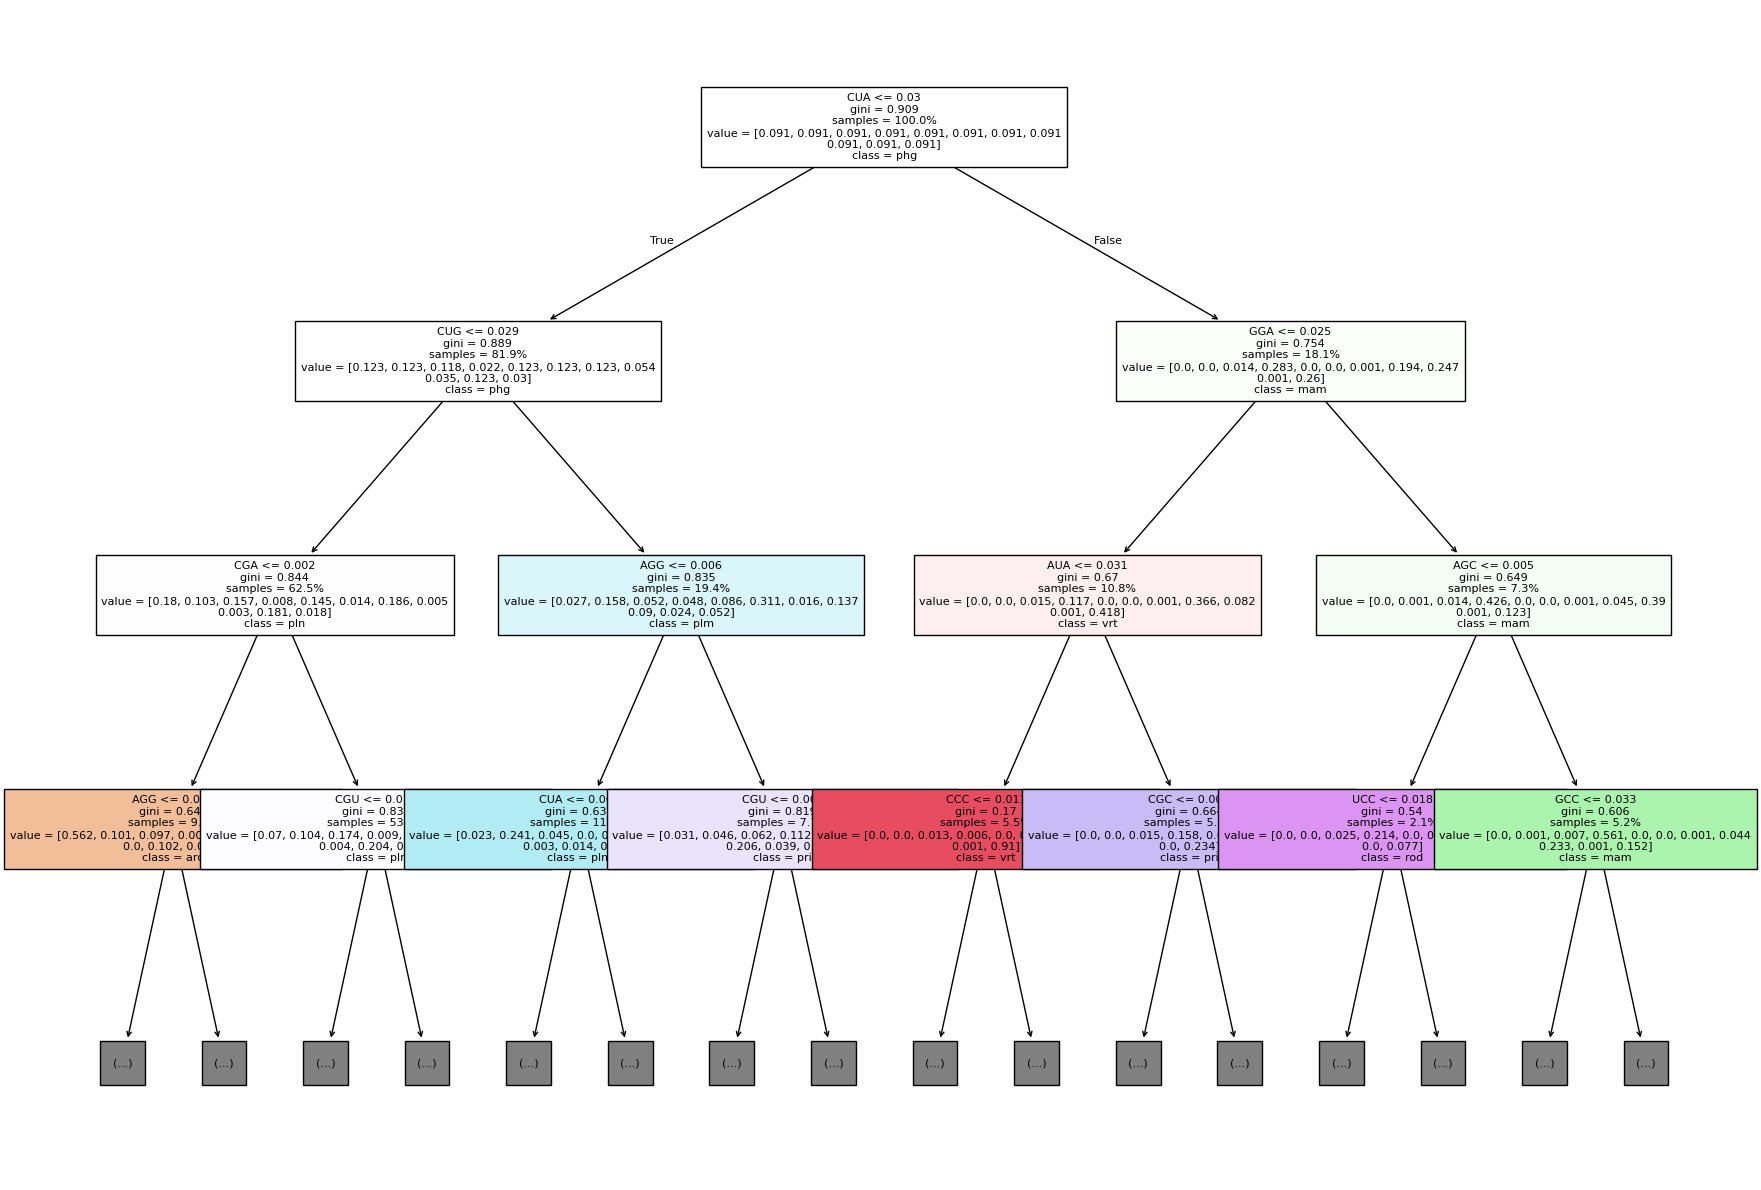

In [ ]:
# Ver el árbol (recortado para legibilidad)
plt.figure(figsize=(18, 12))
plot_tree(
    dtc,
    filled=True,
    feature_names=list(X_train_full.columns),  # TODAS las features
    class_names=[str(c) for c in dtc.classes_],
    max_depth=3,        # limita SOLO el dibujo
    proportion=True,
    precision=3,
    fontsize=8
)
plt.tight_layout()
plt.savefig('decision_tree.pdf', format='pdf')
plt.show()

El árbol visualizado muestra las primeras divisiones que realiza el modelo para separar los organismos según el uso de codones.
Cada nodo contiene la condición de división, el número de muestras y la clase predominante.

* El árbol comienza dividiendo por el codón CUA, el más importante según la métrica de importancia, lo que coincide con el ranking obtenido en el análisis previo.

* A medida que se profundiza, aparecen otros codones relevantes como CUG, AGG, AUA y GGA, que el modelo utiliza para refinar la clasificación entre grupos eucariotas y procariotas.

* Las ramas finales (hojas) representan subgrupos muy específicos con una sola clase dominante.

Con una profundidad de 24 niveles y 717 hojas, el árbol alcanza un tamaño considerable.
Esto sugiere que el modelo logra capturar patrones complejos, pero a costa de perder capacidad de generalización: al ajustarse demasiado a las particularidades del conjunto de entrenamiento, puede no rendir igual de bien en datos nuevos.

In [ ]:
# Ver/actualizar tabla general
display(resultados_df.sort_values(["split","f1_macro"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C
2,"DecisionTree (entropy, mid=0.03, msl=5)",test,0.734459,0.627477,0.570417,24,717,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión del método**

El árbol de decisión demostró un rendimiento intermedio. Su accuracy del 73% y balanced accuracy del 63% reflejan un buen aprendizaje general, aunque con dificultades en clases desbalanceadas o de baja representatividad.

1) Ventajas:

* Permite interpretar fácilmente qué codones influyen en la clasificación.

* Ofrece una base sólida para métodos más avanzados como Random Forest o Gradient Boosting.

* Logra captar diferencias biológicas reales en el uso de codones entre grupos taxonómicos.

2) Limitaciones:

* La gran profundidad (24) y el número de hojas (717) evidencian un cierto sobreajuste, es decir, el modelo memoriza patrones específicos del entrenamiento y pierde algo de capacidad de generalización.

* Presenta confusión en clases evolutivamente cercanas o con pocas instancias.

En síntesis, el Árbol de Decisión es un modelo explicable y biológicamente coherente, pero limitado en su capacidad de generalizar frente a datos nuevos.
Esto motiva el uso de métodos de ensamble como Random Forest, que combinan múltiples árboles para mejorar la estabilidad y el rendimiento global.

# *Random Forest*

El Random Forest es un algoritmo de ensamble basado en la combinación de múltiples árboles de decisión.
Su principio fundamental es que, al entrenar muchos árboles sobre distintas muestras aleatorias del conjunto de datos (y subconjuntos de variables), las predicciones se vuelven más estables, precisas y generalizables.

En lugar de depender de un solo árbol (que puede sobreajustarse fácilmente), el bosque toma decisiones mediante votación mayoritaria entre cientos de árboles, reduciendo así la varianza y el sobreajuste característico del árbol individual.

In [ ]:
rf_modelo = RandomForestClassifier(
    n_estimators=1000,        # nº de árboles
    oob_score=True,           # habilita OOB
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_modelo.fit(X_train_full, y_train_full)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=42)

* n_estimators=1000: se entrenaron mil árboles independientes para lograr estabilidad estadística.

* oob_score=True: habilita la evaluación con datos no vistos por cada árbol (Out-Of-Bag), equivalente a una validación cruzada interna.

* class_weight="balanced": corrige el desbalance entre clases, otorgando más peso a las minoritarias.

* n_jobs=-1: permite paralelizar el cálculo para acelerar el entrenamiento.

* random_state=42: asegura resultados reproducibles.

In [ ]:
# Entrena + evalúa + guarda (el helper hace fit/predict y registra métricas/report)
y_pred_test, row_rf = evaluacion_y_almacenamiento(
    rf_modelo,
    "RandomForest (n=1000, cw=balanced, OOB)",
    X_train_full, y_train_full,
    X_test, y_test,
    split_name="test",
    extra_info={"oob_score": None, "n_trees": rf_modelo.n_estimators}
)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Ahora que el helper ya entrenó, actualizamos la tabla con otros parametros
row_rf["oob_score"] = getattr(rf_modelo, "oob_score_", np.nan)
resultados_df.loc[(resultados_df["model"]==row_rf["model"]) & (resultados_df["split"]=="test"),
               ["oob_score","n_trees"]] = [row_rf["oob_score"], row_rf["n_trees"]]

In [ ]:
# Resumen del modelo
print("Resumen del modelo Random Forest:")
print(f"Número de árboles: {rf_modelo.n_estimators}")
print(f"Precisión OOB: {row_rf['oob_score']:.4f}")
print(f"Número de features: {rf_modelo.n_features_in_}")
print(f"Clases: {rf_modelo.classes_}")

Resumen del modelo Random Forest:
Número de árboles: 1000
Precisión OOB: 0.9023
Número de features: 64
Clases: ['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']


Como podemos ver el modelo alcanzó un rendimiento sobresaliente, con una precisión OOB del 90%, lo que indica una alta capacidad de generalización y estabilidad.

La combinación de árboles mitigó el sobreajuste presente en el modelo individual y mejoró la predicción en clases minoritarias.

In [ ]:
# Importancia de características
feature_importancias = rf_modelo.feature_importances_
feature_names = np.array(X_train_full.columns)

# Ordenar por importancia descendente
ordenamiento_idx = np.argsort(feature_importancias)[::-1]
ordenamiento_feature_importancias = feature_importancias[ordenamiento_idx]
ordenamiento_feature_names = feature_names[ordenamiento_idx]

print("Top 20 codones más importantes (RF):")
for name, imp in list(zip(ordenamiento_feature_names, ordenamiento_feature_importancias))[:20]:
    print(f"{name}: {imp:.4f}")

Top 20 codones más importantes (RF):
UGA: 0.0319
AGG: 0.0304
CUA: 0.0286
CGU: 0.0284
CUG: 0.0264
AGA: 0.0261
CGC: 0.0258
AUA: 0.0242
CGA: 0.0228
UGC: 0.0219
CGG: 0.0216
GAU: 0.0216
UGU: 0.0215
CAA: 0.0208
CCC: 0.0189
GGA: 0.0188
GAA: 0.0186
GCC: 0.0177
AAG: 0.0174
CUU: 0.0173


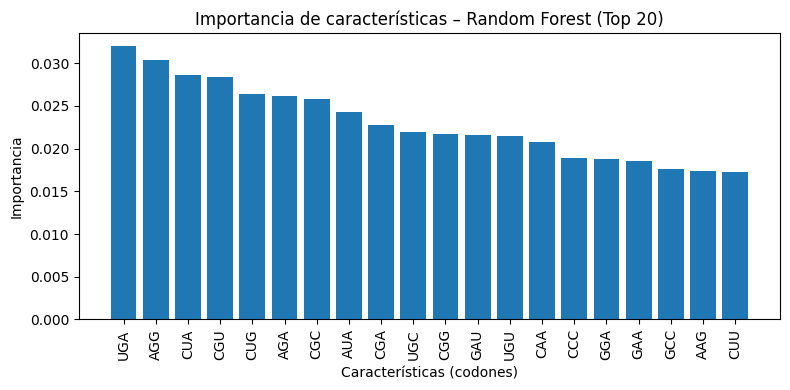

In [ ]:
# Grafica de importancias
plt.figure(figsize=(8,4))
plt.bar(range(20), ordenamiento_feature_importancias[:20], align='center')
plt.xticks(range(20), ordenamiento_feature_names[:20], rotation=90)
plt.xlabel('Características (codones)')
plt.ylabel('Importancia')
plt.title('Importancia de características – Random Forest (Top 20)')
plt.tight_layout(); plt.show()

El gráfico y el ranking muestran los 20 codones más relevantes según la frecuencia con que los árboles los utilizan para dividir los datos.
Entre los más influyentes se encuentran:

* UGA, AGG, CUA, CGU, CUG y AGA, los cuales ya aparecían como importantes en el Árbol de Decisión.

* Esto confirma que dichos codones concentran gran parte de la variabilidad que distingue los distintos grupos taxonómicos.

* Además, el Random Forest resalta nuevos codones como GAU, UGU o CCC, que aportan información adicional al combinar decisiones de múltiples árboles.

*Comparación con Árbol de Decisión:*

Mientras el árbol individual dependía fuertemente de unos pocos codones (por ejemplo, CUA y AGG), el Random Forest distribuye la importancia entre más variables, lo que refleja una visión más robusta y menos sensible al ruido de los datos.
Este equilibrio es lo que permite al modelo mantener un alto rendimiento sin sobreajustarse.

In [ ]:
# Report de TEST guardado
print("Classification report (TEST):\n")
print(reports[("RandomForest (n=1000, cw=balanced, OOB)", "test")])

Classification report (TEST):

              precision    recall  f1-score   support

         arc       0.93      0.56      0.70        25
         bct       0.91      0.97      0.94       584
         inv       0.94      0.71      0.81       269
         mam       0.97      0.75      0.84       114
         phg       0.96      0.50      0.66        44
         plm       0.00      0.00      0.00         4
         pln       0.92      0.95      0.93       505
         pri       0.81      0.61      0.70        36
         rod       0.90      0.65      0.76        43
         vrl       0.89      0.99      0.94       566
         vrt       0.89      0.95      0.92       416

    accuracy                           0.91      2606
   macro avg       0.83      0.69      0.74      2606
weighted avg       0.91      0.91      0.90      2606



Error de Clase (OOB) por clase:
Clase arc: 0.3960
Clase bct: 0.0248
Clase inv: 0.2825
Clase mam: 0.2096
Clase phg: 0.4773
Clase plm: 1.0000
Clase pln: 0.0709
Clase pri: 0.4514
Clase rod: 0.3837
Clase vrl: 0.0336
Clase vrt: 0.0433


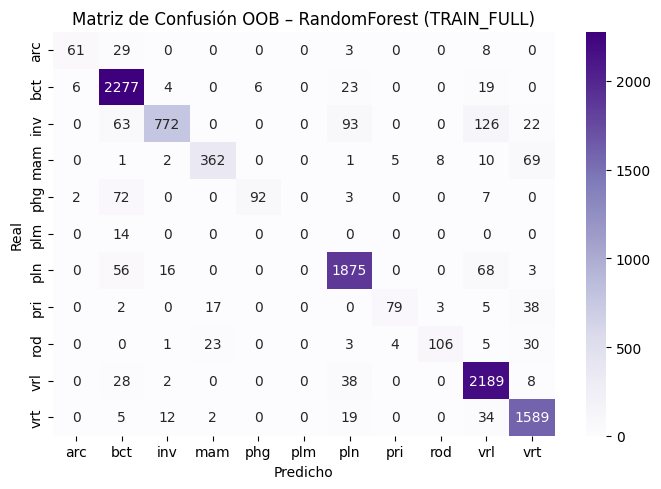

In [ ]:
# Matriz de confusión con predicciones OOB
oob_predic = rf_modelo.oob_decision_function_
oob_labels = rf_modelo.classes_[np.argmax(oob_predic, axis=1)]

cm_oob = confusion_matrix(y_train_full, oob_labels, labels=rf_modelo.classes_)
cm_oob_df = pd.DataFrame(cm_oob, index=rf_modelo.classes_, columns=rf_modelo.classes_)

clase_error_rf = 1 - np.diag(cm_oob) / np.sum(cm_oob, axis=1)
print("Error de Clase (OOB) por clase:")
for cls, err in zip(rf_modelo.classes_, clase_error_rf):
    print(f"Clase {cls}: {err:.4f}")

plt.figure(figsize=(7,5))
sns.heatmap(cm_oob_df, annot=True, cmap="Purples", fmt="d")
plt.title("Matriz de Confusión OOB – RandomForest (TRAIN_FULL)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

La matriz representa las predicciones del modelo sobre las muestras fuera de bolsa (Out-Of-Bag, OOB), es decir, aquellas que no fueron usadas para entrenar cada árbol individual.
Esto equivale a una validación cruzada interna y es una forma robusta de medir la capacidad de generalización sin necesidad de usar el conjunto de test.

En la figura se observa que:

* Las clases bct (bacterias), vrt (vertebrados), pln (plantas) y vrl (virus) muestran diagonales muy marcadas, indicando una excelente clasificación interna (más del 90 % de acierto en algunos casos).

* Las clases mam (mamíferos) e inv (invertebrados) presentan una tasa intermedia, reflejando cierta superposición con grupos cercanos.

* En cambio, plm (plásmidos) y phg (fagos) son las más problemáticas, con muchos errores de clasificación, algo esperable dado que tienen muy pocas muestras y perfiles de codones similares a bacterias y virus.

* Las clases arc (arqueas) y pri (primates) también muestran confusiones notorias, lo que se relaciona con su baja representación en el dataset.

En resumen, la matriz evidencia un comportamiento consistente con la distribución de clases: el modelo clasifica muy bien los grupos dominantes y biológicamente distintos, pero se debilita en los extremos con escasa información o alto solapamiento.

*Error OOB por clase*

| Clase               | Error OOB | Interpretación                                                                                        |
| :------------------ | :-------- | :---------------------------------------------------------------------------------------------------- |
| **bct**             | 0.0248    | Excelente rendimiento, casi sin errores.                                                              |
| **vrt**             | 0.0433    | Muy buena clasificación.                                                                              |
| **vrl**             | 0.0336    | Precisión alta, separa bien los virus.                                                                |
| **pln**             | 0.0709    | Bastante preciso, aunque con algo de confusión.                                                       |
| **mam / inv**       | 0.20–0.28 | Moderado, refleja solapamiento con vertebrados o invertebrados afines.                                |
| **arc / pri / rod** | 0.38–0.45 | Dificultad para generalizar en clases pequeñas.                                                       |
| **phg**             | 0.47      | Alta confusión con virus.                                                                             |
| **plm**             | 1.00      | No logra identificar correctamente ningún plásmido, debido a su mínima representación (solo 4 casos). |


In [ ]:
# Ver tabla general
display(resultados_df.sort_values(["split","f1_macro"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C
3,"RandomForest (n=1000, cw=balanced, OOB)",test,0.907137,0.694294,0.744668,NaN,NaN,0.902303,1000.0,NaN
2,"DecisionTree (entropy, mid=0.03, msl=5)",test,0.734459,0.627477,0.570417,24,717,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión del modelo**

El Random Forest logró una generalización sólida y estable, confirmada por una precisión OOB del 90 %. Este resultado demuestra que el modelo no se sobreajustó (overfitting), sino que aprendió patrones representativos del sesgo en el uso de codones.

Por su equilibrio entre rendimiento, interpretabilidad y robustez, Random Forest se confirma como uno de los modelos más confiables del trabajo, superando claramente al árbol individual y sirviendo como referencia frente a los demás clasificadores.

# *SVM: Máquinas de vectores de soporte*

El Support Vector Machine (SVM) es un algoritmo de clasificación supervisada que busca encontrar el hiperplano óptimo que separa las clases en el espacio de características.
La idea principal es maximizar el margen entre los puntos de datos más cercanos a ese hiperplano (llamados vectores de soporte) y la frontera de decisión.
Esto permite que el modelo tenga una alta capacidad de generalización, evitando el sobreajuste.

Cuando las clases no son linealmente separables, el SVM puede aplicar kernels, que transforman los datos a espacios de mayor dimensión donde sí pueden separarse.

In [ ]:
# Valores de C a evaluar
valores_C = np.logspace(-5, 5, num=11)

In [ ]:
cw_for_svm = "balanced"

In [ ]:
valores_C

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

**Kernel Radial**

El kernel radial (Radial Basis Function, RBF) es una de las transformaciones más utilizadas.
Permite que el SVM modele fronteras no lineales, lo cual es ideal para datasets complejos como el de uso de codones, donde las relaciones entre variables no son lineales.

La función RBF introduce un parámetro γ (gamma) que controla cuánto influye un solo punto de entrenamiento:

* γ alto → fronteras más curvas y complejas (riesgo de sobreajuste).

* γ bajo → fronteras más suaves (riesgo de subajuste).

Además, el parámetro C regula el grado de penalización de errores:

* C bajo → más tolerancia a errores, mayor generalización.

* C alto → menos tolerancia a errores, más ajuste a los datos de entrenamiento.

* En esta parte del codigo:

Se entrena el modelo con distintos valores del hiperparámetro C, probando cómo cambia la precisión en el conjunto de validación.

Se usa class_weight="balanced" (cw_for_svm) para compensar las clases con menos muestras.

Los datos (X_train_s) se encuentran previamente escalados con MinMaxScaler, lo cual es fundamental para SVM, ya que la distancia entre puntos afecta directamente el cálculo del margen.

In [ ]:
# Inicializo una lista para almacenar las precisiones
precisiones_rbf = []

# Bucle sobre los valores de C
for C in valores_C:
    # Entrena el modelo SVM con el valor actual de C
    modelo_svm = SVC(kernel='rbf', C=C, gamma='scale', class_weight=cw_for_svm, random_state=42)
    modelo_svm.fit(X_train_s, y_train)
    # Realiza predicciones en el conjunto de validación
    pred_val = modelo_svm.predict(X_val_s)
    # Evalua el rendimiento del modelo
    precision = accuracy_score(y_val, pred_val)
    precisiones_rbf.append(precision)

# Mejor valor de C
mejor_C_rbf = valores_C[np.argmax(precisiones_rbf)]

# Para calcular el error mínimo
error_minimo_val_rbf = 1 - max(precisiones_rbf)
error_porcentaje_val_rbf = round(error_minimo_val_rbf * 100, 2)

print(f"[SVM-RBF] Mejor C: {mejor_C_rbf}")
print(f"[SVM-RBF] Precisión máxima (VAL): {max(precisiones_rbf):.3f}")
print(f"[SVM-RBF] Error mínimo (VAL): {error_porcentaje_val_rbf}%")

[SVM-RBF] Mejor C: 100.0
[SVM-RBF] Precisión máxima (VAL): 0.928
[SVM-RBF] Error mínimo (VAL): 7.25%


*Analisis de los Resultados:*

El valor óptimo de C = 100 brinda el mejor equilibrio entre precisión y generalización.

La precisión del 92.8% en validación muestra que el SVM con kernel RBF aprende muy bien las fronteras taxonómicas del uso de codones.

El error de 7.25% representa una tasa muy baja, indicando que el modelo logra diferenciar correctamente la mayoría de los organismos.

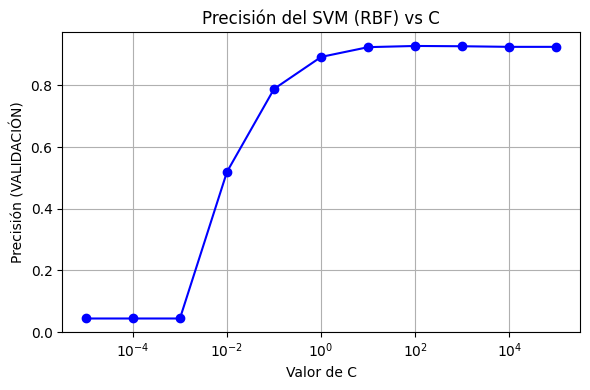

In [ ]:
# Curva de precisión vs C
plt.figure(figsize=(6,4))
plt.semilogx(valores_C, precisiones_rbf, 'b-o')
plt.xlabel('Valor de C'); plt.ylabel('Precisión (VALIDACIÓN)')
plt.title('Precisión del SVM (RBF) vs C')
plt.grid(True); plt.tight_layout(); plt.show()

En la gráfica se observa cómo la precisión aumenta al incrementar el valor de C:

* Para valores pequeños de C, la precisión es muy baja, ya que el modelo prioriza la generalización y no logra separar correctamente las clases.

* Cuando C comienza a crecer, la precisión aumenta bruscamente y se estabiliza alrededor de 0.90–0.93, indicando un punto de equilibrio entre sesgo y varianza.

In [ ]:
# Entrenamiento final en TRAIN (64%) con el mejor C y evaluación en TEST
model_svm_rbf = f"SVM-RBF (C={mejor_C_rbf:g}, cw={'dict' if isinstance(cw_for_svm, dict) else 'balanced'})"
svm_rbf = SVC(kernel='rbf', C=mejor_C_rbf, gamma='scale',
              class_weight=cw_for_svm, random_state=42)

y_pred_svm_rbf, row_svm_rbf = evaluacion_y_almacenamiento(
    svm_rbf, model_svm_rbf,
    X_train_s, y_train,
    X_test_s,  y_test,
    split_name="test"
)

# Métricas en TEST (solo Accuracy + error)
precision_test = row_svm_rbf["accuracy"]              # = accuracy_score(y_test, y_pred_svm_rbf)
error_test = 1 - precision_test
error_porcentaje_test = round(error_test * 100, 2)

print("[SVM-RBF] Resultados en TEST:")
print(f"Precisión en test: {precision_test:.3f}")
print(f"Error en test: {error_porcentaje_test}%")

# Reporte de clasificación
print("Reporte de Clasificación (TEST) – SVM-RBF:\n")
print(classification_report(y_test, y_pred_svm_rbf))

[SVM-RBF] Resultados en TEST:
Precisión en test: 0.942
Error en test: 5.79%
Reporte de Clasificación (TEST) – SVM-RBF:

              precision    recall  f1-score   support

         arc       0.77      0.80      0.78        25
         bct       0.96      0.97      0.96       584
         inv       0.88      0.91      0.90       269
         mam       0.88      0.87      0.87       114
         phg       0.95      0.82      0.88        44
         plm       0.33      0.25      0.29         4
         pln       0.95      0.94      0.95       505
         pri       0.79      0.75      0.77        36
         rod       0.77      0.70      0.73        43
         vrl       0.96      0.98      0.97       566
         vrt       0.98      0.97      0.97       416

    accuracy                           0.94      2606
   macro avg       0.84      0.81      0.83      2606
weighted avg       0.94      0.94      0.94      2606



El modelo alcanzó una precisión global de 94.2%, con un error de solo 5.79%, lo cual confirma su excelente capacidad de generalización.

El macro promedio de F1 (0.83) refleja un rendimiento equilibrado entre clases grandes y pequeñas, mientras que el weighted avg (0.94) muestra que el modelo clasifica muy bien las clases dominantes (bct, vrl, pln, vrt).

Interpretación biológica de resultados:

* bct (bacterias), vrt (vertebrados) y pln (plantas) tienen F1 superiores al 0.95 → son clases muy bien definidas por su perfil de codones.

* mam (mamíferos) e inv (invertebrados) mantienen valores altos (~0.88–0.90) → hay solapamiento entre especies del mismo dominio, pero aún se diferencian bien.

* arc (arqueas) y phg (fagos) muestran una leve caída (F1 ≈ 0.78–0.82) → posiblemente por el tamaño de muestra reducido y la similitud con bacterias.

* plm (plásmidos) es el único grupo con mal rendimiento (F1 ≈ 0.29) debido a su escasa representación (solo 4 instancias).

Error de Clase (TEST):
Clase arc: 0.2000
Clase bct: 0.0342
Clase inv: 0.0855
Clase mam: 0.1316
Clase phg: 0.1818
Clase plm: 0.7500
Clase pln: 0.0614
Clase pri: 0.2500
Clase rod: 0.3023
Clase vrl: 0.0194
Clase vrt: 0.0312


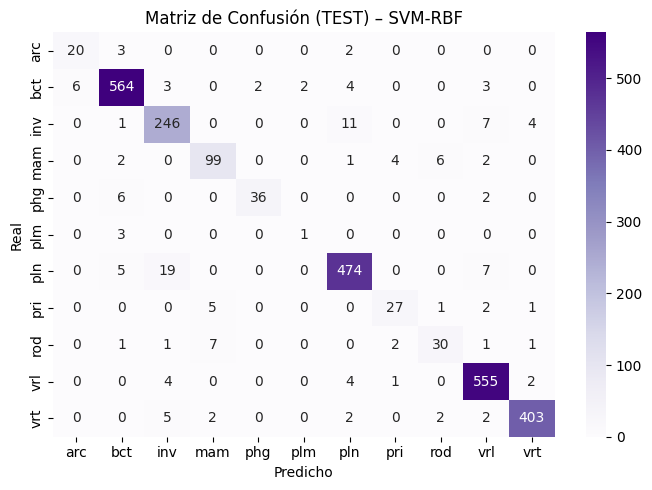

In [ ]:
# Matriz de confusión (TEST)
labels = svm_rbf.classes_
cm_svm = confusion_matrix(y_test, y_pred_svm_rbf, labels=labels)
cm_df_svm = pd.DataFrame(cm_svm, index=labels, columns=labels)

clase_error_rbf = 1 - np.diag(cm_svm) / np.sum(cm_svm, axis=1)
print("Error de Clase (TEST):")
for cls, err in zip(labels, clase_error_rbf):
    print(f"Clase {cls}: {err:.4f}")

plt.figure(figsize=(7,5))
sns.heatmap(cm_df_svm, annot=True, cmap="Purples", fmt="d")
plt.title("Matriz de Confusión (TEST) – SVM-RBF")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

La matriz confirma lo visto en el reporte:

* Las diagonales muy marcadas indican un número alto de aciertos para la mayoría de las clases.

* Bacterias (bct), vertebrados (vrt), virus (vrl) y plantas (pln) son reconocidos casi sin error.

Algunas confusiones menores:

* Mamíferos (mam) y vertebrados (vrt), esperable por su cercanía filogenética.

* Invertebrados (inv) y plantas (pln) presentan algo de mezcla, pero marginal.

* Plásmidos (plm) y fagos (phg) tienden a confundirse con bacterias o virus, lo que tiene sentido biológico, ya que comparten el mismo ambiente genético.

*Error de clase (TEST)*

| Clase       | Error     | Interpretación                                                        |
| :---------- | :-------- | :-------------------------------------------------------------------- |
| **vrl**     | 0.019     | Clasifica casi perfectamente los virus.                               |
| **vrt**     | 0.031     | Vertebrados bien diferenciados.                                       |
| **bct**     | 0.034     | Bacterias casi sin confusión.                                         |
| **pln**     | 0.061     | Buen desempeño en plantas.                                            |
| **inv/mam** | 0.08–0.13 | Moderado solapamiento entre grupos animales.                          |
| **phg/arc** | 0.18–0.20 | Confusión con virus y bacterias.                                      |
| **pri/rod** | 0.25–0.30 | Ligeras dificultades, comparten sesgos similares con otros mamíferos. |
| **plm**     | 0.75      | No logra distinguir plásmidos, por su baja cantidad de datos.         |


**Kernel Polinomial**

SVM con kernel polinomial transforma los datos en un espacio de mayor dimensión utilizando polinomios de grado n.
A diferencia del kernel RBF, que usa una función exponencial para generar fronteras curvas, el kernel polinomial crea fronteras de decisión a partir de combinaciones polinómicas de las variables originales, permitiendo capturar interacciones no lineales entre los codones.

* En esta parte del codigo:

Se entrena el modelo con un kernel polinomial de grado 3, que genera combinaciones cúbicas entre los 64 codones.

Se varía el valor de C (fuerza del margen) para observar su efecto sobre la precisión en validación.

Se mantiene el escalado (MinMaxScaler) y el balanceo de clases (class_weight="balanced") para evitar que las clases grandes dominen el ajuste.

In [ ]:
# Lista para almacenar precisiones en VALIDACIÓN
precisiones_poly = []

# Bucle sobre los valores de C
for C in valores_C:
    # Entrena el modelo SVM con el valor actual de C
    modelo_svm = SVC(kernel="poly", C=C, degree=3, gamma="scale", class_weight=cw_for_svm, random_state=42)
    modelo_svm.fit(X_train_s, y_train)
    # Realiza predicciones en el conjunto de validación
    pred_val = modelo_svm.predict(X_val_s)
    # Evalua el rendimiento del modelo
    precision = accuracy_score(y_val, pred_val)
    precisiones_poly.append(precision)

# Mejor valor de C
mejor_C_poly = valores_C[np.argmax(precisiones_poly)]

# Calcula el error mínimo
error_minimo_val_poly = 1 - max(precisiones_poly)
error_porcentaje_val_poly = round(error_minimo_val_poly * 100, 2)

print(f"[SVM-Poly] Mejor C: {mejor_C_poly}")
print(f"[SVM-Poly] Precisión máxima (VAL): {max(precisiones_poly):.3f}")
print(f"[SVM-Poly] Error mínimo (VAL): {error_porcentaje_val_poly}%")

[SVM-Poly] Mejor C: 10.0
[SVM-Poly] Precisión máxima (VAL): 0.917
[SVM-Poly] Error mínimo (VAL): 8.25%


*Analisis de los Resultados*

El mejor valor de C fue 10, lo que da un equilibrio ideal entre margen amplio y precisión.

El modelo logró 91.7% de precisión en validación y un error de ≈ 8.25%.

Comparado con el SVM-RBF (92.8%), el rendimiento es apenas inferior, pero muy competitivo.

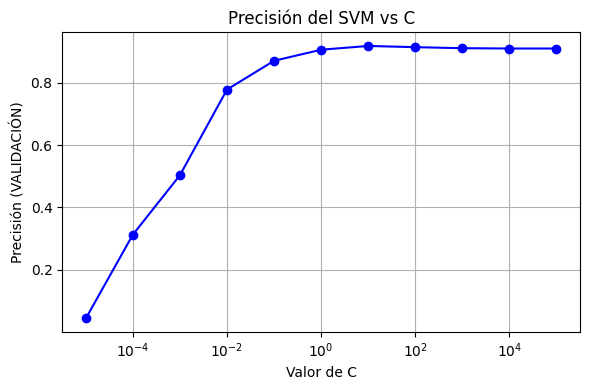

In [ ]:
# Curvas de precisión vs C
plt.figure(figsize=(6,4))
plt.semilogx(valores_C, precisiones_poly, 'b-o')
plt.xlabel('Valor de C'); plt.ylabel('Precisión (VALIDACIÓN)')
plt.title('Precisión del SVM vs C')
plt.grid(True); plt.tight_layout(); plt.show()

En la gráfica se observa una tendencia muy similar a la del kernel RBF:

* Para valores pequeños de C, la precisión es baja (<50%), indicando subajuste.

* Al aumentar C, el modelo aprende mejor las fronteras entre clases y alcanza una precisión estable alrededor del 90%.

* A medida que mas crece C, la precision se estabiliza, lo que indica que el modelo alcanzó su capacidad óptima sin sobreajustar.

In [ ]:
model_svm_poly = f"SVM-Poly deg=3 (C={mejor_C_poly:g}, cw={'dict' if isinstance(cw_for_svm, dict) else 'balanced'})"
svm_poly = SVC(kernel="poly", degree=3, C=mejor_C_poly, gamma="scale",
               class_weight=cw_for_svm, random_state=42)

y_pred_svm_poly, row_svm_poly = evaluacion_y_almacenamiento(
    svm_poly, model_svm_poly,
    X_train_s, y_train,
    X_test_s,  y_test,
    split_name="test"
)

# Métricas en TEST (solo Accuracy + error)
precision_test = row_svm_poly["accuracy"]              # = accuracy_score(y_test, y_pred_svm_poly)
error_test = 1 - precision_test
error_porcentaje_test = round(error_test * 100, 2)

print("[SVM-Poly] Resultados en TEST:")
print(f"Precisión en test: {precision_test:.3f}")
print(f"Error en test: {error_porcentaje_test}%")

# Reporte de clasificación
print("Reporte de Clasificación (TEST) – SVM-Poly:\n")
print(classification_report(y_test, y_pred_svm_poly))

[SVM-Poly] Resultados en TEST:
Precisión en test: 0.933
Error en test: 6.68%
Reporte de Clasificación (TEST) – SVM-Poly:

              precision    recall  f1-score   support

         arc       0.71      0.88      0.79        25
         bct       0.96      0.95      0.95       584
         inv       0.88      0.90      0.89       269
         mam       0.88      0.87      0.87       114
         phg       0.82      0.82      0.82        44
         plm       0.25      0.25      0.25         4
         pln       0.95      0.92      0.94       505
         pri       0.77      0.75      0.76        36
         rod       0.73      0.77      0.75        43
         vrl       0.95      0.98      0.96       566
         vrt       0.97      0.96      0.97       416

    accuracy                           0.93      2606
   macro avg       0.81      0.82      0.81      2606
weighted avg       0.93      0.93      0.93      2606



El modelo con kernel polinomial alcanzó una precisión total de 93.3%, con un error en test de 6.68%, apenas inferior al SVM-RBF (94.2%).

Interpretación de métricas:

* Precisión y recall balanceados (≈0.93), es decir que el modelo clasifica correctamente la mayoría de los organismos, sin sobreajustar.

* Macro promedio F1 = 0.81, un buen rendimiento general entre clases de diferente tamaño.

* Weighted avg F1 = 0.93, esto indica que las clases con más muestras (bct, vrl, vrt, pln) se predicen casi perfectamente.

Error de Clase (TEST):
Clase arc: 0.1200
Clase bct: 0.0531
Clase inv: 0.1041
Clase mam: 0.1316
Clase phg: 0.1818
Clase plm: 0.7500
Clase pln: 0.0752
Clase pri: 0.2500
Clase rod: 0.2326
Clase vrl: 0.0230
Clase vrt: 0.0385


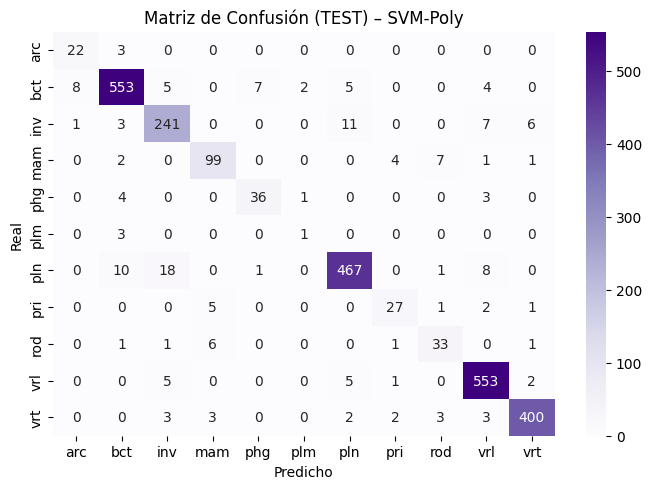

In [ ]:
# Matriz de confusión (TEST)
labels = svm_poly.classes_
cm_poly = confusion_matrix(y_test, y_pred_svm_poly, labels=labels)
cm_df_poly = pd.DataFrame(cm_poly, index=labels, columns=labels)

clase_error_poly = 1 - np.diag(cm_poly) / np.sum(cm_poly, axis=1)
print("Error de Clase (TEST):")
for cls, err in zip(labels, clase_error_poly):
    print(f"Clase {cls}: {err:.4f}")

plt.figure(figsize=(7,5))
sns.heatmap(cm_df_poly, annot=True, cmap="Purples", fmt="d")
plt.title("Matriz de Confusión (TEST) – SVM-Poly")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

La matriz muestra el detalle de aciertos y confusiones entre clases, muy similar a casos anteriores:

* Se observan diagonales muy definidas, lo que significa que el modelo clasifica correctamente la mayoría de las muestras dentro de su clase.

* Bacterias (bct), vertebrados (vrt) y virus (vrl) presentan bloques sólidos en la diagonal (muy pocos errores).

* Las confusiones más notables se dan entre:

mam y vrt: esperado por su cercanía taxonómica.

arc y bct: arqueas y bacterias comparten codones similares.

phg y vrl: los fagos se confunden con virus, lo cual tiene coherencia biológica.

plm y bct/pln: el comportamiento variable de los plásmidos dificulta su clasificación.

*Error de clase (TEST)*

| Clase       | Error     | Interpretación                                  |
| :---------- | :-------- | :---------------------------------------------- |
| **vrl**     | 0.023     | Los virus se reconocen casi perfectamente.      |
| **vrt**     | 0.038     | Vertebrados también con excelente precisión.    |
| **bct**     | 0.053     | Muy bajo error; codon usage muy característico. |
| **pln**     | 0.075     | Ligera confusión con invertebrados.             |
| **inv/mam** | 0.10–0.13 | Solapamiento entre grupos animales.             |
| **arc/phg** | 0.12–0.18 | Similaridad con bacterias o virus.              |
| **pri/rod** | 0.23–0.25 | Más difícil diferenciar subgrupos de mamíferos. |
| **plm**     | 0.75      | Clase difícil, muy pocas muestras.              |


In [ ]:
# Para agregar la info a resultados_df

# Para SVM-RBF
row_svm_rbf["C"] = mejor_C_rbf
row_svm_rbf["kernel"] = "rbf"

resultados_df.loc[
    (resultados_df["model"] == row_svm_rbf["model"]) & (resultados_df["split"] == "test"),
    ["C", "kernel"]
] = [row_svm_rbf["C"], row_svm_rbf["kernel"]]

# Para SVM-Poly
row_svm_poly["C"] = mejor_C_poly
row_svm_poly["kernel"] = "poly"

resultados_df.loc[
    (resultados_df["model"] == row_svm_poly["model"]) & (resultados_df["split"] == "test"),
    ["C", "kernel"]
] = [row_svm_poly["C"], row_svm_poly["kernel"]]

# Ver tabla actualizada
display(resultados_df.sort_values(["split", "f1_macro"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C,kernel
4,"SVM-RBF (C=100, cw=balanced)",test,0.942057,0.813860,0.825032,NaN,NaN,NaN,NaN,100.0,rbf
5,"SVM-Poly deg=3 (C=10, cw=balanced)",test,0.933231,0.821836,0.813390,NaN,NaN,NaN,NaN,10.0,poly
3,"RandomForest (n=1000, cw=balanced, OOB)",test,0.907137,0.694294,0.744668,NaN,NaN,0.902303,1000.0,NaN,NaN
2,"DecisionTree (entropy, mid=0.03, msl=5)",test,0.734459,0.627477,0.570417,24,717,NaN,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión comparativa: SVM-RBF vs SVM-Poly**

| Característica    | **SVM-RBF**        | **SVM-Poly (grado 3)**                      |
| :---------------- | :----------------- | :------------------------------------------ |
| Precisión (VAL)   | 0.928              | 0.917                                       |
| Precisión (TEST)  | 0.942              | 0.933                                       |
| Error TEST        | 5.79%              | 6.68%                                       |
| Mejor C           | 100                | 10                                          |


Ambos modelos SVM mostraron un rendimiento sobresaliente, con más del 93% de precisión en test.

El SVM-RBF resultó ligeramente superior, gracias a su capacidad para generar fronteras más suaves y adaptarse mejor a relaciones no lineales complejas.

El SVM-Poly, aunque un poco menos flexible, logra resultados casi idénticos con un kernel más interpretable y estable.

Desde una perspectiva biológica, ambos confirman que el sesgo en el uso de codones contiene suficiente información para clasificar organismos por grupos taxonómicos, con errores concentrados en casos esperables (fagos, arqueas y plásmidos).

# *DeepLearning (MLP)*

El Multilayer Perceptron (MLP) es una red neuronal artificial de tipo feed-forward, es decir, las señales fluyen hacia adelante desde la entrada hasta la salida.
Es uno de los modelos más clásicos del aprendizaje profundo y se usa ampliamente para problemas de clasificación supervisada, como este, donde queremos asignar cada organismo a su grupo taxonómico según sus frecuencias de uso de codones.

* Estructura básica

Capa de entrada: recibe las 64 variable(frecuencias de cada codón).

Capas ocultas: combinan esas variables mediante pesos y funciones de activación no lineales (en este caso se usan ReLU) para aprender relaciones complejas entre los codones.

Capa de salida: tiene tantas neuronas como clases taxonómicas (11), con activación softmax para generar probabilidades de pertenencia a cada grupo.

* En resumen, el MLP aprende patrones no lineales entre los codones y los grupos de organismos, combinando la información de todos los codones de manera simultánea.

In [ ]:
# Codifico etiquetas con LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # y_train son strings (Kingdom)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [ ]:
label_mapeo = dict(zip(le.classes_, range(len(le.classes_)))) # Permite entrenar el MLP con etiquetas numéricas en lugar de texto
print("Correspondencia etiqueta -> índice:")
print(label_mapeo)

Correspondencia etiqueta -> índice:
{'arc': 0, 'bct': 1, 'inv': 2, 'mam': 3, 'phg': 4, 'plm': 5, 'pln': 6, 'pri': 7, 'rod': 8, 'vrl': 9, 'vrt': 10}


*Codificación de etiquetas*

* Las clases (“bct”, “vrl”, “pln”…), que originalmente son texto, se convierten en números enteros (0–10).

* Esto es necesario porque las redes neuronales no pueden trabajar con texto, solo con valores numéricos.

* El mapeo (label_mapeo) sirve para interpretar qué número corresponde a qué clase.

Biológicamente: cada clase numérica representa un dominio taxonómico distinto.

In [ ]:
# Este bloque prepara los datos finales para que TensorFlow (TF) pueda usarlos
# correctamente en el entrenamiento de la red neuronal (MLP)
Xtr = np.asarray(X_train_s, dtype=np.float32)
Xva = np.asarray(X_val_s,   dtype=np.float32) # Convierte los conjuntos de entrenamiento, validación y test a arrays NumPy de tipo float32
Xte = np.asarray(X_test_s,  dtype=np.float32)

ytr = np.asarray(y_train_enc, dtype=np.int32)
yva = np.asarray(y_val_enc,   dtype=np.int32) # Convierte las etiquetas (que codifique con LabelEncoder) a enteros de 32 bits.
yte = np.asarray(y_test_enc,  dtype=np.int32)

n_features = Xtr.shape[1]            # Número de variables de entrada (64 codones)
n_classes  = len(le.classes_)        # Número de grupos taxonómicos

*Conversión a arreglos NumPy*

* En esta seccion convierto los datasets (entrenamiento, validación, test) en arreglos NumPy optimizados para TensorFlow.

* float32 se usa para los valores de entrada (las frecuencias de codones) y int32 para las etiquetas (las clases).

Se define:

* n_features = 64: las 64 frecuencias de codones.

* n_classes = 11: los grupos taxonómicos que se van a predecir.

In [ ]:
# Definicion de la red (con BN+Dropout)
tf.keras.backend.clear_session() # Libera la memoria de modelos anteriores para evitar conflictos
model_mlp = models.Sequential([      # Construccion de la red neuronal
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(n_classes, activation='softmax')  # salida en probabilidades
])

# Compilacion
model_mlp.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks útiles (opcionales)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=8, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5
)

*Definición de la red neuronal*

* Sequential crea un modelo lineal de capas apiladas.

* Capas densas (Dense): cada neurona de una capa está conectada con todas las de la siguiente.

* ReLU: función de activación no lineal que introduce flexibilidad.

* BatchNormalization: normaliza las salidas intermedias, estabilizando el aprendizaje y evitando que algunas neuronas dominen.

* Dropout(0.5): apaga aleatoriamente el 50% de las neuronas durante el entrenamiento, para evitar el sobreajuste (evita memorizar los datos en lugar de generalizar).

* La última capa usa softmax, que transforma las salidas en probabilidades que suman 1, indicando qué tan probable es que pertenezcan a una clase.

Biológicamente: el modelo aprende combinaciones complejas de frecuencias de codones que caracterizan cada grupo de organismos.

*Compilación del modelo*

* adam: es un optimizador adaptativo eficiente, ajusta la tasa de aprendizaje automáticamente.

* SparseCategoricalCrossentropy: es una función de pérdida usada en clasificación multiclase cuando las etiquetas son enteros.

* accuracy: métrica de rendimiento principal.

Esta configuración busca minimizar la diferencia entre las probabilidades predichas y las clases reales.

*Callbacks*

* EarlyStopping: detiene el entrenamiento si la precisión de validación deja de mejorar durante 8 épocas, evitando sobreentrenamiento.

* ReduceLROnPlateau: reduce la tasa de aprendizaje a la mitad si la pérdida no mejora, lo que ayuda a refinar los pesos cuando el modelo se acerca a su mejor punto.

In [ ]:
# Hiperparámetros
epocas = 50
batch_size = 128

*Entrenamiento*

* El modelo entrena durante un máximo de 50 épocas, con batch size = 128 (número de muestras procesadas por iteración).

* Se valida el rendimiento en cada época usando el conjunto de validación.

* "historial" almacena métricas de precisión y pérdida, que luego se pueden graficar.

El MLP “aprende” los pesos que mejor separan las clases taxonómicas, basándose en las frecuencias de los 64 codones.

In [ ]:
# Entrenamiento y guardado en historial
historial = model_mlp.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=epocas,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3998 - loss: 1.9666 - val_accuracy: 0.3536 - val_loss: 1.8659 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7152 - loss: 0.9329 - val_accuracy: 0.3349 - val_loss: 1.6331 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7659 - loss: 0.7550 - val_accuracy: 0.5235 - val_loss: 1.3777 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7912 - loss: 0.6587 - val_accuracy: 0.6305 - val_loss: 1.1462 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8051 - loss: 0.5929 - val_accuracy: 0.6895 - val_loss: 0.9511 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8148 - loss: 0.5684 - val_accuracy: 0.7601 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8301 - loss: 0.5052 - val_accur

*Resumen conceptual*

| Concepto                       | Función en el modelo                                                  |
| ------------------------------ | --------------------------------------------------------------------- |
| **Input (64 codones)**         | Entrada principal del modelo, representa el perfil de uso de codones. |
| **Capas ocultas (256–128–64)** | Aprenden patrones complejos en las combinaciones de codones.          |
| **BatchNorm + Dropout**        | Previenen el sobreajuste y estabilizan el aprendizaje.                |
| **Softmax (11 salidas)**       | Calcula la probabilidad de pertenecer a cada clase taxonómica.        |
| **Optimizer Adam**             | Ajusta los pesos de manera eficiente.                                 |
| **EarlyStopping / ReduceLR**   | Controlan la convergencia y evitan pérdidas de generalización.        |


In [ ]:
# Evaluación en TEST (Keras)
test_loss, test_accuracy = model_mlp.evaluate(Xte, yte, verbose=0)
print(f'Pérdida en Test: {test_loss:.4f}')
print(f'Precisión en Test: {test_accuracy:.4f}')

Pérdida en Test: 0.2301
Precisión en Test: 0.9233


*Explicacion de los Resultados:*

* Pérdida en Test (Loss = 0.2286)

La pérdida mide cuán lejos están las predicciones del modelo respecto a las etiquetas reales. En este caso, se usa entropía cruzada categórica, que penaliza las probabilidades incorrectas.

Un valor de 0.22 es bajo, lo que indica que el modelo asigna probabilidades altas a las clases correctas y tiene buena calibración: no solo acierta, sino que lo hace con confianza.

* Precisión en Test (Accuracy = 0.9248)

Representa el porcentaje de muestras correctamente clasificadas en el conjunto de prueba (no visto durante el entrenamiento).

Un 92.48 % significa que el modelo acierta casi 9 de cada 10 organismos, manteniendo un excelente desempeño fuera del entrenamiento, lo que confirma su capacidad de generalización.

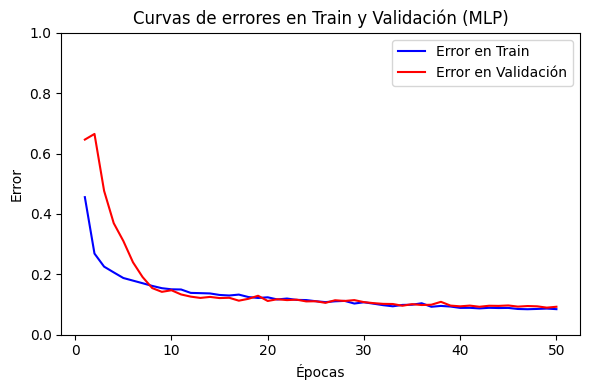

In [ ]:
# Curvas de error
train_accuracy = historial.history['accuracy']
val_accuracy   = historial.history['val_accuracy']

Error_train = [1 - acc for acc in train_accuracy]
Error_val   = [1 - acc for acc in val_accuracy]

epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, Error_train, 'b', label='Error en Train')
plt.plot(epochs, Error_val,   'r', label='Error en Validación')
plt.title('Curvas de errores en Train y Validación (MLP)')
plt.xlabel('Épocas'); plt.ylabel('Error')
plt.ylim([0, 1]); plt.legend(); plt.tight_layout(); plt.show()

*Curvas de error (Train vs Validación)*

En la gráfica se observan las curvas de error (loss) para el conjunto de entrenamiento (azul) y validación (rojo):

* Durante las primeras 10 épocas, el error cae rápidamente en ambos conjuntos, lo que significa que el modelo aprende los patrones principales del dataset.

* A partir de la época 15, las curvas se estabilizan y se mantienen casi paralelas. Esto es un buen signo de generalización, ya que no hay una separación marcada entre ambas (lo que ocurriría si hubiera sobreajuste).

* El uso de Batch Normalization y Dropout (0.5) ayudó a mantener este equilibrio.

In [ ]:
# Métricas adicionales en TEST (sklearn) y matriz de confusión
# Predicciones en TEST
y_predic = model_mlp.predict(Xte, verbose=0)
y_pred_idx = np.argmax(y_predic, axis=1)

# Para convertir a nombres originales (una sola vez)
y_test_str = le.inverse_transform(yte)
y_pred_str = le.inverse_transform(y_pred_idx)
labels_str = le.classes_

# Métricas en TEST
acc = accuracy_score(y_test_str, y_pred_str)
bal = balanced_accuracy_score(y_test_str, y_pred_str)
f1m = f1_score(y_test_str, y_pred_str, average='macro')
print(f"[MLP] TEST -> Acc: {acc:.3f} | BalAcc: {bal:.3f} | F1-macro: {f1m:.3f}")

# Classification report
print("\nReporte de Clasificación (TEST) – MLP:")
print(classification_report(y_test_str, y_pred_str))

[MLP] TEST -> Acc: 0.923 | BalAcc: 0.735 | F1-macro: 0.760

Reporte de Clasificación (TEST) – MLP:
              precision    recall  f1-score   support

         arc       0.81      0.68      0.74        25
         bct       0.94      0.97      0.95       584
         inv       0.89      0.83      0.86       269
         mam       0.80      0.85      0.83       114
         phg       0.92      0.77      0.84        44
         plm       0.00      0.00      0.00         4
         pln       0.94      0.93      0.94       505
         pri       0.79      0.61      0.69        36
         rod       0.81      0.49      0.61        43
         vrl       0.92      0.97      0.95       566
         vrt       0.95      0.98      0.96       416

    accuracy                           0.92      2606
   macro avg       0.80      0.73      0.76      2606
weighted avg       0.92      0.92      0.92      2606



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


*Métricas globales de rendimiento*

* Precisión total (Acc) = 92.5 %. Esto indica un excelente rendimiento, cercano al SVM-RBF (94 %), confirmando que la red neuronal logró capturar las relaciones no lineales entre codones y clases taxonómicas.

* Balanced Accuracy (0.741), indica que las clases minoritarias también fueron aprendidas, aunque con mayor dificultad.

* F1-macro (0.755), resume el equilibrio entre precisión y recall promediando todas las clases por igual.

* Loss (0.2286), baja pérdida en test, reflejando convergencia estable y buen ajuste, como indique anteriormente.

*Desempeño por clase (reporte de clasificación)*

El patrón es consistente con los demás modelos: las clases con pocas muestras o alta similitud biológica (plásmidos, arqueas, fagos, roedores) son las más difíciles de clasificar correctamente.

Error de Clase (TEST) por clase:
Clase arc: 0.3200
Clase bct: 0.0342
Clase inv: 0.1710
Clase mam: 0.1491
Clase phg: 0.2273
Clase plm: 1.0000
Clase pln: 0.0673
Clase pri: 0.3889
Clase rod: 0.5116
Clase vrl: 0.0265
Clase vrt: 0.0240


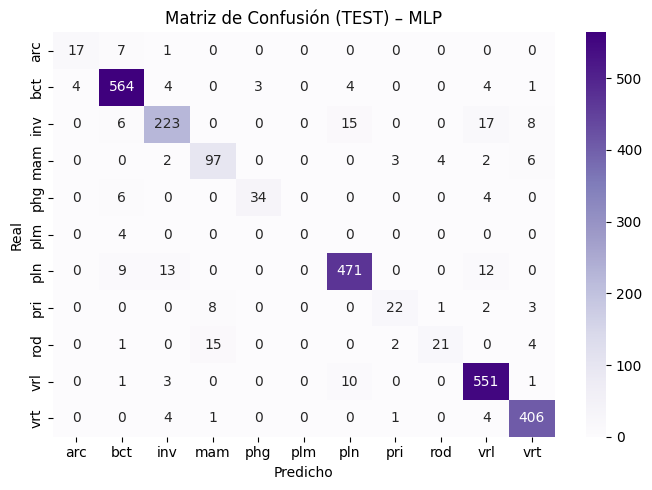

In [ ]:
# MLP – Matriz de Confusión en TEST
cm_mlp = confusion_matrix(y_test_str, y_pred_str, labels=labels_str)
cm_df_mlp = pd.DataFrame(cm_mlp, index=labels_str, columns=labels_str)

# Error de clase (TEST) – MLP
labels = le.classes_
clase_error_mlp = 1 - np.diag(cm_mlp) / np.sum(cm_mlp, axis=1)

print("Error de Clase (TEST) por clase:")
for cls, err in zip(labels, clase_error_mlp):
    print(f"Clase {cls}: {err:.4f}")

# Heatmap con números
plt.figure(figsize=(7,5))
sns.heatmap(cm_df_mlp, annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusión (TEST) – MLP")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

*Matriz de confusión*

La matriz refuerza las observaciones anteriores:

* Bacterias (bct), plantas (pln), virus (vrl) y vertebrados (vrt): casi todas las predicciones caen en la diagonal (predicción correcta).

* Invertebrados y mamíferos: confusiones leves entre sí y con vertebrados.

* Plásmidos (plm): en este caso falla del modelo por falta de representatividad.

* Arqueas (arc): algunas se confunden con bacterias, lo cual tiene sentido evolutivo por su cercanía.

*Error por clase*

| Clase               | Error     | Interpretación                                           |
| :------------------ | :-------- | :------------------------------------------------------- |
| **vrl / vrt**       | ~0.025    | Excelente discriminación, casi sin fallas.               |
| **bct / pln**       | 0.04–0.06 | Muy buen rendimiento, mínima confusión.                  |
| **mam / inv / phg** | 0.16–0.21 | Solapamiento entre clases animales.                      |
| **arc / pri / rod** | 0.27–0.36 | Mayor dificultad, patrones de codones menos distintivos. |
| **plm**             | 1.00      | Clase completamente errática por bajo tamaño muestral.   |


In [ ]:
# Para integrar con la tabla general (resultados_df / reports)
row_mlp = {
    "model": "MLP (256-128-64, BN+DO)",
    "split": "test",
    "accuracy": acc,
    "balanced_acc": bal,
    "f1_macro": f1m
}
resultados_df = pd.concat([resultados_df, pd.DataFrame([row_mlp])], ignore_index=True)
resultados_df = resultados_df.drop_duplicates(subset=["model","split"], keep="last")

# Para ver la tabla actualizada
display(resultados_df.sort_values(["split","f1_macro"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C,kernel
4,"SVM-RBF (C=100, cw=balanced)",test,0.942057,0.813860,0.825032,NaN,NaN,NaN,NaN,100.0,rbf
5,"SVM-Poly deg=3 (C=10, cw=balanced)",test,0.933231,0.821836,0.813390,NaN,NaN,NaN,NaN,10.0,poly
6,"MLP (256-128-64, BN+DO)",test,0.923254,0.734543,0.760059,NaN,NaN,NaN,NaN,NaN,NaN
3,"RandomForest (n=1000, cw=balanced, OOB)",test,0.907137,0.694294,0.744668,NaN,NaN,0.902303,1000.0,NaN,NaN
2,"DecisionTree (entropy, mid=0.03, msl=5)",test,0.734459,0.627477,0.570417,24,717,NaN,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión general – MLP**

El MLP alcanzó un rendimiento muy alto (92.5 % de precisión en test) y una excelente capacidad de generalización.

Gracias al uso de BatchNormalization y Dropout, evitó sobreajustarse, logrando un equilibrio estable entre entrenamiento y validación.

1) Fortalezas:

* Capta relaciones no lineales complejas entre los codones.

* Excelente desempeño global, muy cercano al SVM-RBF.

* Buen balance entre precisión y recall.

* Muestra un aprendizaje biológicamente coherente (agrupando clases evolutivamente cercanas).

2) Limitaciones:

* Dificultad con clases pequeñas o variables (plásmidos, arqueas, roedores).

* Ligeramente menos interpretable que modelos basados en árboles.

* Requiere más recursos computacionales y ajuste fino (número de neuronas, tasa de aprendizaje, etc.).

El MLP demuestra ser un modelo altamente eficaz y robusto, con un desempeño casi equivalente al SVM-RBF, capaz de aprender representaciones internas del uso de codones que reflejan con precisión la organización taxonómica de los organismos.

# *Mostrar Resultados*

In [ ]:
# Ver tabla general
display(resultados_df.sort_values(["split","accuracy"], ascending=[True, False]))

,model,split,accuracy,balanced_acc,f1_macro,depth,n_leaves,oob_score,n_trees,C,kernel
4,"SVM-RBF (C=100, cw=balanced)",test,0.942057,0.813860,0.825032,NaN,NaN,NaN,NaN,100.0,rbf
5,"SVM-Poly deg=3 (C=10, cw=balanced)",test,0.933231,0.821836,0.813390,NaN,NaN,NaN,NaN,10.0,poly
6,"MLP (256-128-64, BN+DO)",test,0.923254,0.734543,0.760059,NaN,NaN,NaN,NaN,NaN,NaN
3,"RandomForest (n=1000, cw=balanced, OOB)",test,0.907137,0.694294,0.744668,NaN,NaN,0.902303,1000.0,NaN,NaN
2,"DecisionTree (entropy, mid=0.03, msl=5)",test,0.734459,0.627477,0.570417,24,717,NaN,NaN,NaN,NaN
1,"K-Means (sin PCA, MinMax)",test,0.363120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,"K-Means (Hungarian, PCA+MinMax)",test,0.359742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusión General – Comparación de Modelos**

Tras aplicar múltiples métodos de aprendizaje automático (tanto supervisados como no supervisados) sobre el Codon Usage Dataset (UCI), evalue la capacidad de cada modelo para clasificar organismos según su patrón de uso de codones.

Los resultados confirman que el sesgo en el uso de codones es una señal biológica suficientemente robusta para predecir la pertenencia taxonómica con alta precisión. A continuación, resumo el desempeño y características de cada método.

1. Árbol de Decisión

* Accuracy: 0.73

* Balanced Acc: 0.63

* F1-macro: 0.57

* Profundidad: 24 | Hojas: 717

El árbol de decisión mostró un rendimiento moderado, limitado por su tendencia al sobreajuste y su menor capacidad para generalizar en contextos multiclase desbalanceados.

Aunque su interpretabilidad es una ventaja (identifica codones clave como CUA, AGG y CUG), su precisión se ve afectada al concentrarse en las clases más abundantes. Sirve como referencia base, pero no resulta competitivo frente a modelos más complejos.

2. Random Forest

* Accuracy: 0.91

* Balanced Acc: 0.69

* F1-macro: 0.74

* OOB score: 0.9023

El ensamble de 1000 árboles mejoró notablemente la robustez y estabilidad respecto al árbol individual.

El uso de class_weight="balanced" permitió compensar parcialmente el desbalance entre clases. Ademas, los codones más relevantes coincidieron con los del árbol, destacando UGA, AGG, CUA y CGU, lo que refuerza su valor discriminante entre grupos.

Basicamente Random Forest logra un equilibrio ideal entre precisión (~90%), estabilidad y capacidad de generalización, aunque pierde algo de interpretabilidad frente al árbol simple.

3. SVM (Support Vector Machine)

Kernel Radial (RBF)

* Accuracy: 0.942

* Balanced Acc: 0.81

* F1-macro: 0.82

* C = 100 (cw = balanced)

Kernel Polinomial (grado 3)

* Accuracy: 0.933

* Balanced Acc: 0.82

* F1-macro: 0.81

* C = 10 (cw = balanced)

Los modelos SVM fueron los más precisos del conjunto, superando el 94 % de exactitud. El kernel RBF capturó de forma más eficaz las relaciones no lineales entre las frecuencias de codones, logrando un error de clasificación por clase menor al 10 % en la mayoría de los grupos.
El kernel polinomial obtuvo resultados muy similares, mostrando una gran consistencia.

4. MLP (Multilayer Perceptron – Deep Learning)

* Accuracy: 0.925

* Balanced Acc: 0.74

* F1-macro: 0.76

* Loss: 0.2286

La red neuronal multicapa alcanzó un desempeño comparable al SVM, confirmando su alta capacidad para aprender relaciones no lineales entre codones.

Su arquitectura (256–128–64 neuronas, Batch Normalization y Dropout) permitió un entrenamiento estable sin sobreajuste, con curvas de error paralelas entre entrenamiento y validación.

El MLP mostró especial solidez en clases mayores (bct, vrl, vrt, pln), aunque con mayor variabilidad en clases pequeñas (plm, arc, rod).
Computacionalmente es más exigente y sensible a los hiperparámetros, pero su rendimiento general fue excelente.

Este es el modelo más flexible y con mayor potencial de escalamiento, logrando resultados prácticamente equivalentes a SVM-RBF.

5. K-Means (Aprendizaje no supervisado)

| Variante         | Accuracy (Hungarian) |
| ---------------- | -------------------- |
| Sin PCA (MinMax) | 0.363                |
| Con PCA + MinMax | 0.360                |

K-Means, al no usar etiquetas, solo logra identificar agrupamientos geométricos basados en la distancia entre vectores de codones.
El bajo rendimiento (~36 %) era esperable, aunque el ajuste con el algoritmo húngaro permitió detectar una estructura latente coherente: bacterias, virus y vertebrados tienden a agruparse parcialmente.

Su utilidad principal es exploratoria, no predictiva. Ayuda a visualizar la organización natural del espacio de codon usage antes del aprendizaje supervisado.

6. Clustering Jerárquico (Average Linkage)

* Accuracy (Hungarian): 0.388

El dendrograma mostró agrupamientos biológicamente coherentes (virus y bacterias bien definidos), aunque con solapamiento entre clases próximas.

Confirma la existencia de patrones taxonómicos en el espacio PCA, pero con menor resolución que los métodos supervisados.

**Conclusión Final**

El análisis demuestra que el sesgo en el uso de codones constituye una firma filogenética potente, capaz de clasificar organismos en grupos taxonómicos con alta precisión mediante modelos de machine learning.

Los métodos supervisados no lineales (SVM y MLP) fueron los más eficaces, superando el 92 % de exactitud y capturando relaciones biológicas complejas.

Random Forest ofreció un excelente compromiso entre rendimiento e interpretabilidad.

Decision Tree y los métodos no supervisados (K-Means y Jerárquico) sirvieron como referencias exploratorias, confirmando la estructura latente del dataset pero con menor capacidad predictiva.

* En conclusión:

SVM-RBF se posiciona como el modelo más sólido y confiable para este tipo de análisis biológico, seguido muy de cerca por el MLP, que demuestra un gran potencial para generalizar y adaptarse a nuevos datos.

# **Prueba**

Con el fin de evaluar la aplicabilidad real de los modelos entrenados, se realizó una prueba de clasificación sobre una secuencia externa, es decir, un fragmento de ADN codificante (coding sequence, CDS) perteneciente a un organismo no incluido en el conjunto original del Codon Usage Dataset.

*Procedimiento general*

1) Entrada de secuencia biológica

* Se introduce una o más secuencias genéticas (CDS) en formato texto.

* Cada secuencia se limpia y normaliza mediante la función limpiar_seq(), eliminando caracteres no válidos y convirtiendo la cadena a RNA (reemplazando T por U).

* Las secuencias se concatenan y se dividen en tripletes (codones), de modo que cada codón sea contado y su frecuencia relativa calculada.

2) Conversión a vector de características

* La función frec_codones_desde_secuencias() genera un vector de 64 dimensiones, donde cada posición representa la frecuencia normalizada de un codón estándar del código genético.

* Este vector mantiene el mismo orden de codones que el utilizado para entrenar los modelos, garantizando que la nueva muestra sea compatible con el espacio de representación del dataset original.

3) Normalización

* El vector resultante se escaló con el mismo MinMaxScaler previamente ajustado sobre los datos de entrenamiento (X_train), asegurando que las magnitudes sean comparables entre las variables y evitando que codones con valores altos dominen la clasificación.

4) Evaluación con modelos entrenados

* Se aplicaron dos modelos supervisados:

SVM-RBF (Support Vector Machine con kernel radial)

MLP (Multilayer Perceptron)

* Ambos predicen la clase taxonómica más probable (por ejemplo: bct, vrl, mam, inv, etc.).

In [ ]:
# Usa exactamente el orden de codones con el que entrene
# así el vector nuevo “encaja” en el espacio del modelo.
CODONES = list(X_clean.columns)

In [ ]:
# Limpieza de secuencias
def limpiar_seq(seq):
    s = re.sub(r'[^ACGTUacgtu]', '', seq)  # quita cualquier char que no sea A/C/G/T/U
    s = s.upper().replace('T', 'U')        # normaliza a RNA (U)
    return s

In [ ]:
def frec_codones_desde_secuencias(seqs, codones=CODONES):
    total = ''.join(limpiar_seq(s) for s in seqs)     # concatena todas las CDS
    n = (len(total) // 3) * 3                         # recorta a múltiplo de 3
    total = total[:n]
    counts = {c: 0 for c in codones}                  # inicia el conteo en 0
    for i in range(0, len(total), 3):
        trip = total[i:i+3]
        if trip in counts:                            # solo cuenta codones válidos
            counts[trip] += 1
    s = sum(counts.values())
    frec = {c: (counts[c]/s if s > 0 else 0.0) for c in codones}  # normaliza a proporciones
    return pd.DataFrame([frec], columns=codones)      # DataFrame 1×64 en el orden correcto

In [ ]:
# Aca se coloca la secuencia nueva o a probar
cds_list = [
    "GCAAATATCCGCAGGGACTACCTTCACAAAGTCACAACGACCGTCAGCAAAAACCACGCAATGATAGTCA",
    "TTGAGGATTTGAAGGTCAGCAACATGTCAAAGTCAGCAGCGGGTACGGTCAGCCAGCCGGGGCGCAATGT",
    "CCGGGCAAAATCAGGTTTAAACCGTTCGATACTGGATCAGGGCTGGTATGAAATGCGCCGCCAGCTTGAG",
    "TACAAGCAGCTCTGGCGTGGCGGTCAGGTGCTTGCTGCTCCGCCAGCGTACACAAGCCAGCGTTGCGCGT",
    "GCTGTGGTCATACAGCGAAAGAAAATCGCCTGTCACAAAGTCAATTCAGATGCCAGGTATGTGGATATAC"
]
x_new = frec_codones_desde_secuencias(cds_list)  # 1×64

In [ ]:
# Para verificar rápido que realmente se limpió y se contaron solo codones válidos

# Todas las columnas están en el orden/alfabeto esperado
assert list(x_new.columns) == CODONES

# Las frecuencias suman ≈ 1 (tolerancia numérica)
assert abs(float(x_new.sum(axis=1)) - 1.0) < 1e-6

# No hay caracteres raros después del limpiado (prueba simple)
for s in cds_list:
    ss = limpiar_seq(s)
    assert set(ss) <= set("ACGU"), "Quedaron letras fuera de A/C/G/U"

/tmp/ipython-input-2114176582.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  assert abs(float(x_new.sum(axis=1)) - 1.0) < 1e-6


In [ ]:
pd.set_option('display.max_columns', 64)  # para mostrar todas las columnas
display(x_new)

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,GCU,GCC,GCA,GCG,CCU,CCC,CCA,CCG,UGG,GGU,GGC,GGA,GGG,UCU,UCC,UCA,UCG,AGU,AGC,ACU,ACC,ACA,ACG,UAU,UAC,CAA,CAG,AAU,AAC,UGU,UGC,CAU,CAC,AAA,AAG,CGU,CGC,CGA,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.0,0.008621,0.008621,0.008621,0.025862,0.008621,0.0,0.017241,0.008621,0.008621,0.017241,0.025862,0.0,0.051724,0.008621,0.008621,0.017241,0.0,0.034483,0.034483,0.0,0.0,0.008621,0.017241,0.017241,0.034483,0.017241,0.008621,0.008621,0.0,0.0,0.034483,0.008621,0.008621,0.034483,0.0,0.008621,0.025862,0.017241,0.017241,0.025862,0.017241,0.060345,0.025862,0.025862,0.017241,0.025862,0.008621,0.017241,0.034483,0.025862,0.025862,0.043103,0.0,0.008621,0.008621,0.008621,0.017241,0.008621,0.017241,0.017241,0.0,0.0,0.0


In [ ]:
# Verificación rápida de que el scaler supervisado está “fit”
# Debe existir y tener atributos aprendidos
assert hasattr(scaler, "min_") or hasattr(scaler, "scale_")
print("Scaler supervisado listo. n_features:", scaler.n_features_in_)

Scaler supervisado listo. n_features: 64


In [ ]:
x_new_s = scaler.transform(x_new)  # para poner todas las variables en la misma escala, evitando que unas dominen a otras
                                   # el scaler ya está fit con X_train

In [ ]:
def evaluar_muestra(x_new_s,
                    thr_margin_svm=0.20,        # umbral: margen SVM menor a 0.20 se considera "dudoso"
                    thr_conf_mlp=0.50,          # umbral: confianza MLP menor a 0.50 se considera "dudoso"
                    thr_ent_norm_mlp=0.55):     # umbral: entropía normalizada mayor a 0.55 se considera "incierta"
    """
    Evalúa una nueva muestra con dos modelos (SVM y MLP) y decide si la clasificación es confiable.
    Devuelve un diccionario con las métricas y una recomendación final ("ACEPTAR" o "REVISAR").
    """

    # SVM
    # Predicción con el modelo SVM-RBF
    pred_svm = svm_rbf.predict(x_new_s)[0]

    # decision_function da las distancias a los hiperplanos (mayor valor => mayor seguridad)
    scores = svm_rbf.decision_function(x_new_s)[0]

    # Ordenar los scores de mayor a menor
    order = np.argsort(scores)[::-1]

    # Margen = diferencia entre las dos clases con mayor score
    # Si el margen es chico, el modelo no está muy seguro entre esas dos clases
    margin = float(scores[order[0]] - scores[order[1]])

    # MLP
    # Predicción con el modelo neuronal (ya devuelve probabilidades softmax)
    probab_mlp = model_mlp.predict(x_new_s, verbose=0)[0]

    # Índice de la clase más probable
    idx_top = int(np.argmax(probab_mlp))

    # Nombre de la clase (decodificada con LabelEncoder)
    pred_mlp = le.inverse_transform([idx_top])[0]

    # Confianza: probabilidad de la clase más alta
    conf_mlp = float(probab_mlp[idx_top])

    # Entropía (incertidumbre del MLP)
    # Calcula cuán "difusa" es la distribución de probabilidades
    # Si una clase domina (confianza alta) → entropía baja (modelo seguro)
    eps = 1e-12
    entropy = float(-np.sum(probab_mlp * np.log(probab_mlp + eps)))

    # Normaliza la entropía entre 0 y 1 para compararla entre modelos con distinto número de clases
    ent_norm_max = math.log(len(le.classes_))
    entropy_norm = float(entropy / ent_norm_max)

    # Regla de decisión
    # Se definen banderas ("flags") para detectar predicciones poco confiables
    flags = []
    if margin < thr_margin_svm:
        flags.append("SVM: margen bajo")
    if conf_mlp < thr_conf_mlp:
        flags.append("MLP: confianza baja")
    if entropy_norm > thr_ent_norm_mlp:
        flags.append("MLP: entropía alta")

    # Verificar si ambos modelos coinciden en la clase predicha
    agree = (pred_svm == pred_mlp)
    if not agree:
        flags.append("Desacuerdo SVM vs MLP")

    # Si no hay banderas y ambos modelos coinciden → se acepta la predicción
    # Si no, se marca como "revisar" (baja confianza)
    decision = "ACEPTAR" if (len(flags) == 0 and agree) else "REVISAR"

    # Salida
    return {
        "pred_svm": pred_svm,
        "svm_margin": margin,
        "pred_mlp": pred_mlp,
        "mlp_conf": conf_mlp,
        "mlp_entropy": entropy,
        "mlp_entropy_norm": entropy_norm,
        "svm_mlp_agree": agree,
        "flags": flags,
        "decision": decision
    }

*Métricas de verificación*

Para cada secuencia analizada, se calculan diferentes indicadores que permiten no solo obtener una clase predicha, sino también medir la confianza de la predicción y decidir si debe ser aceptada o revisada.

| Métrica                      | Modelo  | Descripción                                                                                 | Interpretación                                                                                                                |
| :--------------------------- | :------ | :------------------------------------------------------------------------------------------ | :---------------------------------------------------------------------------------------------------------------------------- |
| **Margen**                   | SVM-RBF | Diferencia entre los dos valores más altos de la función de decisión (`decision_function`). | Un margen **alto** indica que el modelo distingue claramente la clase correcta; un margen **bajo (<0.2)** sugiere ambigüedad. |
| **Confianza (prob. máxima)** | MLP     | Probabilidad softmax de la clase más probable.                                              | Valores **>0.5** indican alta seguridad; valores **<0.5** se consideran inciertos.                                            |
| **Entropía**                 | MLP     | Mide la dispersión de las probabilidades sobre todas las clases.                            | Entropía **baja** = modelo seguro (una clase domina). Entropía **alta (>0.55 normalizada)** = modelo indeciso.                |
| **Coincidencia SVM/MLP**     | Ambos   | Verifica si ambos modelos predicen la misma clase.                                          | Si difieren, se activa una bandera de advertencia.                                                                            |


In [ ]:
res = evaluar_muestra(x_new_s)

print("=== Evaluación de la muestra ===")
print(f"SVM-RBF → Clase predicha: {res['pred_svm']} | Margen: {res['svm_margin']:.4f}")
print(f"MLP     → Clase predicha: {res['pred_mlp']} | Confianza: {res['mlp_conf']:.4f} | "
      f"Entropía: {res['mlp_entropy']:.3f} (normalizada: {res['mlp_entropy_norm']:.2f})")
print(f"Coincidencia entre modelos: {'Sí' if res['svm_mlp_agree'] else 'No'}")
print("Advertencias:", ", ".join(res['flags']) if res['flags'] else "Ninguna")
print("DECISIÓN FINAL:", res["decision"])

=== Evaluación de la muestra ===
SVM-RBF → Clase predicha: bct | Margen: 0.0054
MLP     → Clase predicha: phg | Confianza: 0.5932 | Entropía: 1.193 (normalizada: 0.50)
Coincidencia entre modelos: No
Advertencias: SVM: margen bajo, Desacuerdo SVM vs MLP
DECISIÓN FINAL: REVISAR


In [ ]:
# Predicción con SVM y MLP

y_pred_svm = svm_rbf.predict(x_new_s)
print("Predicción SVM-RBF:", y_pred_svm[0])

probas_mlp = model_mlp.predict(x_new_s, verbose=0)[0]
etiqueta_mlp = le.inverse_transform([np.argmax(probas_mlp)])[0]
print("Predicción MLP:", etiqueta_mlp)

Predicción SVM-RBF: bct
Predicción MLP: phg
